<div class="pull-right">
    made by
    <a href=https://github.com/sergeimars title=sergeimars>sergeimars</a>
</div>

# Анализ данных по продажам видеоигр

План работы следующий:

- ознакомиться со структурой данных;
- выявить проблемы в виде дубликатов, пропусков и неверных форматов, и найти оптимальные пути для их устранения;
- изучить данные на предмет аномальных значений;
- избавиться от выбросов;
- оценить объем удаленных данных, при необходимости повторить итерацию для снижения доли в случае риска искажения данных;
- провести исследовательский анализ данных, убедиться что предыдущие шаги были выполнены верно, при необходимости повторить итерацию;
- расчитать дополнительную аналитику и добавить в датафрейм;
- проверить гипотезы;
- сделать выводы по вопросам с учетом подходящего распределения вероятностей для случайной величины;
- сформировать выводы по итогам проделанной работы.


В нашем распоряжении имеются следующие исторические данные о продажах видеоигр:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from math import factorial
from math import sqrt
from scipy import stats as st
from scipy.stats import binom, norm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

### Откроем файл с данными и изучим общую информацию. 

#### Откроем файл и выведем первые несколько строк датафрейма

In [2]:
try:
    df = pd.read_csv('games.csv')
except:
    print('Не получилось, нужно проверить адрес')
else:
    print('Данные загружены успешно!')

Данные загружены успешно!


Выведем информацию и первые строки датафреймов:

In [3]:
display(df.head(), df.info(), df.describe())
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


None

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


На первый взгляд бросается в глаза заглавные буквы в названиях столбцов, а также значения 'Year_of_Release' в формате float, а 'User_Score' в формате object. С этим мы поработаем на этапе предварительной обработки.

#### Построим общую гистограмму для всех числовых столбцов таблицы

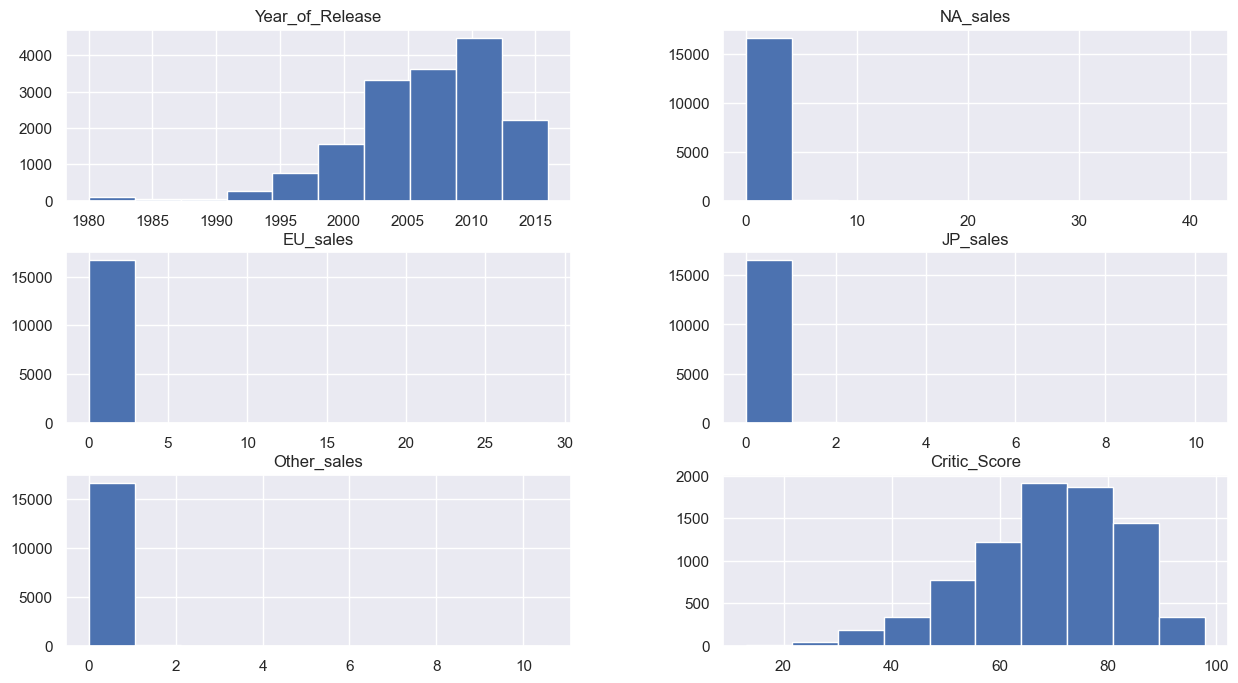

In [4]:
sns.set(rc={'figure.figsize':(15, 8)})
df.hist()
plt.show()

#### Вывод:

В датафрейме 16715 строк, каждая строка содержит данные о конкретной игре, ее жанре, годе релиза, платформе и количественных продажах (в млн. проданных копий) в том или ином регионе, а также рейтингах.
При первичном анализе можно заметить наличие пропусков в данных, а также проблемы с форматированием солбцов и регистре названий столбцов. Также нам предстоит изучить данные на предмет явных и неявных дубликатов, а также аномальных значений.

Чтобы двигаться дальше, нам необходимо устранить проблемы в данных.

### Предобработка данных

#### Регистр и проверка на дубликаты

Приведем название столбцов к «змеиному_регистру»:

In [5]:
df.columns = df.columns.str.lower()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Проверим данные на предмет явных дубликатов:

In [6]:
print(f'Количество дубликатов в датафрейме: {df.duplicated().sum()}')

Количество дубликатов в датафрейме: 0


Явных дубликатов не обнаружено.
Проверим датасет на предмет неявных дубликатов. Наиболее вероятны дубликаты по столбцам:'name', 'platform', 'year_of_release', 'genre' и 'rating'.

In [7]:
display(df.name.sort_values().unique())
display(df.platform.sort_values().unique())
display(df.year_of_release.sort_values().unique())
display(df.genre.sort_values().unique())
display(df.rating.sort_values().unique())

array([' Beyblade Burst', ' Fire Emblem Fates', " Frozen: Olaf's Quest",
       ..., 'wwe Smackdown vs. Raw 2006', '¡Shin Chan Flipa en colores!',
       nan], dtype=object)

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.,   nan])

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy', nan], dtype=object)

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

В целом, уникальные значения не вызывают опасений, за исключением названий игр, содержащих пробел в начале имени.
Небоходимо отметить, что среди рейтингов ESRB имеется рейтинг 'K-A', согласно данным www.esrb.org/history/ , данный рейтинг (Kids to Adults) был заменен рейтингом 'E' (Everyone) в 1998 году,  а рейтинг 'EC' (Early Childhood) был упразднен с 1 марта 2018 г. и также был заменен на рейтнг 'E' (Everyone).
С учетом данной информации целесообразно произвести замену 'K-A' и 'EC' на 'E'.

In [8]:
df.loc[(df['rating'] == 'K-A')|(df['rating'] == 'EC'), 'rating'] = 'E'
display(df.rating.sort_values().unique())

array(['AO', 'E', 'E10+', 'M', 'RP', 'T', nan], dtype=object)

Теперь избавимся от пробелов в начале названия игр:

In [9]:
display(df.name.sort_values().head(10).unique())

array([' Beyblade Burst', ' Fire Emblem Fates', " Frozen: Olaf's Quest",
       ' Haikyu!! Cross Team Match!', ' Tales of Xillia 2', "'98 Koshien",
       '.hack//G.U. Vol.1//Rebirth', '.hack//G.U. Vol.2//Reminisce',
       '.hack//G.U. Vol.2//Reminisce (jp sales)'], dtype=object)

Имеем 5 имен. Скорректируем название и проверим на наличие дубликатов.

In [10]:
old_names = [
    ' Beyblade Burst',
    ' Fire Emblem Fates', 
    " Frozen: Olaf's Quest",
    ' Haikyu!! Cross Team Match!',
    ' Tales of Xillia 2'
]

new_names = [
    'Beyblade Burst',
    'Fire Emblem Fates', 
    "Frozen: Olaf's Quest",
    'Haikyu!! Cross Team Match!',
    'Tales of Xillia 2'
]

for names in df.name.head(10).unique():
    for old, new in zip(old_names, new_names):
        df.loc[df['name'] == names, 'name'] =\
        str(names).replace(old, new)   
        
display(df.name.sort_values().head(10).unique())
print(f'Количество дубликатов в датафрейме: {df.duplicated().sum()}')

array([' Beyblade Burst', ' Fire Emblem Fates', " Frozen: Olaf's Quest",
       ' Haikyu!! Cross Team Match!', ' Tales of Xillia 2', "'98 Koshien",
       '.hack//G.U. Vol.1//Rebirth', '.hack//G.U. Vol.2//Reminisce',
       '.hack//G.U. Vol.2//Reminisce (jp sales)'], dtype=object)

Количество дубликатов в датафрейме: 0


Дубликаты отсутствуют, однако имеются пропуски данных, изучим их более подробно.

#### Обработка пропусков

In [11]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Итак мы имеем пропуски в нескольких столбцах, разберем каждый из них:
- name:
здесь решение отсутствует, данные строки подлежат удалению, во-первых поскольку отсутствует ключевой идентификатор - название игры, во-вторых поскольку это всего лишь 2 строки, которые не окажут существенного влияния на дальнейший анализ.

- year_of_release:
год релиза также достаточно индивидуальный показатель, однако, если изучить датасет более внимательно можно заметить, что одна и та же игра была выпущена на нескольких платформах, и в подавляющем боьшинстве в пределах года. Здесь предлагается заполнить медианным значением при наличии года релиза по данной игре на других платформах. В случае, если данные отсутствуют по игре в целом, также можно воспользоваться следующей логикой: поскольку каждая из игровых платформ имеет свой жизненный цикл, период релизов игр на платформах как правило совпадает с релизами других игр на этих же платформах, поэтому будет справедливо заполнить значения медианой по платформе. Оставшиеся значения, при наличии, рассмотрим индивидуально.

- genre:
жанр также можно позаимстововать из позиций с названием этой же игры, если это невозможно, данные можно удалить. 

- critic_score:
изучив датафрейм можно прийти к выводу, что мультиплатформенные игры имеют схожие оценки критиков на разных платформах, безусловно среди них есть отдельные, выбивающиеся рейтинги, но эту проблему можно решить медианой. Таким образом эти пропуски можно заполнить медианным значением по данной игре на других платформах. При отсутствии рейтинга как такогово необходимо оценить количество таких строк и принять решение об удалении или о сохранении данных.

- user_score:
предлагается использовать подход, аналогичный 'critic_score'.

- rating:
рейтинг ESRB также можно позаимствовать из позиций с тем же названием игр.

Итак, начнем с того, что удалим строки с пропущенными именами, а год релиза заменим медианным значением по названию, поскольку релиз игры носит как правило кросс-платформенный характер, в большинстве случаев, поэтому медианное значение здесь подойдет как нельзя кстати:

In [12]:
df = df.dropna(subset=['name'])

for n in df.loc[df['year_of_release'].isna() == True,'name'].unique():
    if df.loc[(df['name'] == n), 'year_of_release'].sum() > 0:
        df.loc[(df['name'] == n) & (df['year_of_release'].isna()), 'year_of_release'] = \
        df.loc[(df['name'] == n), 'year_of_release'].median()    
    
df.isna().sum()

name                  0
platform              0
year_of_release     146
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

Заметим, что при удалении строк с отсутствующим названием игр, у нас также исключились строки с отсутствием жанра, похоже это были одни и те же позиции.

Чтож, 146 пропусков не удалось устранить по причине отсутствия года выпуска как такового.
Можно предположить, что дата релиза связана с типом платформы, поскольку каждый тип платформы имеет свой жизненный цикл. Исключением является категория PC.
Попробуем заполнить данные с учетом медианы по платформе.

In [13]:
for p in df['platform'].unique():
        if p != 'PC':
            df.loc[(df['platform'] == p) & (df['year_of_release'].isna()), 'year_of_release'] = \
            df.loc[(df['platform'] == p), 'year_of_release'].median()
        
df.isna().sum()

name                  0
platform              0
year_of_release       4
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

In [14]:
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
4648,TERA,PC,NaN,Role-Playing,0.25,0.12,0.0,0.05,77.0,6.8,M
7735,Test Drive Unlimited 2,PC,NaN,Racing,0.05,0.11,0.0,0.03,72.0,5.7,T
13672,Clockwork Empires,PC,NaN,Strategy,0.00,0.04,0.0,0.00,58.0,3.8,RP
16277,Homeworld Remastered Collection,PC,NaN,Strategy,0.00,0.01,0.0,0.00,86.0,8.2,E10+


В целом данные строки можно было бы исключить из датафрейма, и ничего бы не потеряли, но мы возпользовались поиском и нашли информацию по оставшимся четырем играм:
- TERA - 2011;
- Test Drive Unlimited 2 - 2011;
- Clockwork Empires - 2016;
- Homeworld Remastered Collection - 2015.

In [15]:
df.loc[(df['name'] == 'TERA') & (df['platform'] == 'PC'), 'year_of_release'] = 2011
df.loc[(df['name'] == 'Test Drive Unlimited 2') & (df['platform'] == 'PC'), 'year_of_release'] = 2011
df.loc[(df['name'] == 'Clockwork Empires') & (df['platform'] == 'PC'), 'year_of_release'] = 2016
df.loc[(df['name'] == 'Homeworld Remastered Collection') & (df['platform'] == 'PC'), 'year_of_release'] = 2015
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

Теперь разберемся с оценками критиков и пользователей, но прежде, переведем 'user_score' в правильный формат:

In [16]:
display(df.user_score.sort_values().unique())

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Можно заметить, что в колонке 'user_score' имеются позиции со значением tbd, что означает to be determined или подлежит уточнению, что говорит нам о том, что значение оценки отсутствует. Целесообразно заменить данные значения на NaN, и изменить формат данных на float.

In [17]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan
df['user_score'] = df['user_score'].astype(float)

In [18]:
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
dtype: int64

In [19]:
for cs in df.loc[df['critic_score'].isna() == True, 'name'].unique():
    if df.loc[(df['name'] == cs), 'critic_score'].sum() > 0:
        df.loc[(df['name'] == cs) & (df['critic_score'].isna()), 'critic_score'] = \
        df.loc[(df['name'] == cs), 'critic_score'].median()
        
for us in df.loc[df['user_score'].isna() == True, 'name'].unique():
    if df.loc[(df['name'] == us), 'user_score'].sum() > 0:
        df.loc[(df['name'] == us) & (df['user_score'].isna()), 'user_score'] = \
        df.loc[(df['name'] == us), 'user_score'].median()
        
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       7615
user_score         8024
rating             6764
dtype: int64

Часть значений удалось заполнить, однако пропусков все еще довольно много поэтому поскольку пропуски могут повлиять на дальнейший анализ, заполним рейтинги медианой по платформе. 

In [20]:
for pf in df.platform.unique():
    if df.loc[(df['platform'] == pf), 'critic_score'].sum() > 0:
        df.loc[(df['platform'] == pf) & (df['critic_score'].isna()), 'critic_score'] = \
        df.loc[(df['platform'] == pf), 'critic_score'].median()
    if df.loc[(df['platform'] == pf), 'user_score'].sum() > 0:
        df.loc[(df['platform'] == pf) & (df['user_score'].isna()), 'user_score'] = \
        df.loc[(df['platform'] == pf), 'user_score'].median()
        
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score         31
user_score           31
rating             6764
dtype: int64

31 значение можно удалить оно не повияет на дальнейший анализ

In [21]:
df = df.drop(df.loc[df['critic_score'].isna() == True].index)
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score            0
rating             6733
dtype: int64

Теперь разберемся с рейтингом ESRB ('rating'):

In [22]:
for ra in df.loc[df['rating'].isna() == True, 'name'].unique():
    if df.loc[(df['rating'] == pf), 'critic_score'].sum() > 0:
        df.loc[(df['name'] == ra) & (df['rating'].isna()), 'rating'] = \
        df.loc[(df['name'] == ra), 'rating'].values[0]

df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score            0
rating             6733
dtype: int64

Оставшиеся заменим на N/A, поскольку удаление информации слишком чуствительно в данном случае.

In [23]:
df.loc[df['rating'].isna(), 'rating'] = 'N/A'
df.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

#### Формат данных

Проверим данные на предмет корректного формата:

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16682 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16682 non-null  object 
 1   platform         16682 non-null  object 
 2   year_of_release  16682 non-null  float64
 3   genre            16682 non-null  object 
 4   na_sales         16682 non-null  float64
 5   eu_sales         16682 non-null  float64
 6   jp_sales         16682 non-null  float64
 7   other_sales      16682 non-null  float64
 8   critic_score     16682 non-null  float64
 9   user_score       16682 non-null  float64
 10  rating           16682 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


Необходимо 'year_of_release' преобразовать в формат int, а для экономии памяти также изменим формат столбцов c 64-битного типа на 32-битный.

In [25]:
df['year_of_release'] = df['year_of_release'].astype('int32')
df['na_sales'] = df['na_sales'].astype('float32')
df['eu_sales'] = df['eu_sales'].astype('float32')
df['jp_sales'] = df['jp_sales'].astype('float32')
df['other_sales'] = df['other_sales'].astype('float32')
df['critic_score'] = df['critic_score'].astype('float32')
df['user_score'] = df['user_score'].astype('float32')

df['id'] = df.index
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16682 entries, 0 to 16681
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16682 non-null  object 
 1   platform         16682 non-null  object 
 2   year_of_release  16682 non-null  int32  
 3   genre            16682 non-null  object 
 4   na_sales         16682 non-null  float32
 5   eu_sales         16682 non-null  float32
 6   jp_sales         16682 non-null  float32
 7   other_sales      16682 non-null  float32
 8   critic_score     16682 non-null  float32
 9   user_score       16682 non-null  float32
 10  rating           16682 non-null  object 
 11  id               16682 non-null  int64  
dtypes: float32(6), int32(1), int64(1), object(4)
memory usage: 1.1+ MB


#### Расчет суммарных продаж

Создадим столбец 'total_sales' с суммарным значением продаж по каждому региону, путем суммирования столбцов 'na_sales','eu_sales','jp_sales' и 'other_sales':

In [26]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,id,total_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76.0,8.00,E,0,82.539993
1,Super Mario Bros.,NES,1985,Platform,29.080000,3.580000,6.81,0.77,74.0,8.00,N/A,1,40.240002
2,Mario Kart Wii,Wii,2008,Racing,15.680000,12.760000,3.79,3.29,82.0,8.30,E,2,35.520000
3,Wii Sports Resort,Wii,2009,Sports,15.610000,10.930000,3.28,2.95,80.0,8.00,E,3,32.770000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.270000,8.890000,10.22,1.00,85.0,9.05,N/A,4,31.380001


#### Анализ аномальных значений

Изучим данные на предмет аномальных значений:

In [27]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,id,total_sales
count,16682.000000,16682.000000,16682.000000,16682.000000,16682.000000,16682.000000,16682.000000,16682.000000,16682.000000
mean,2006.491068,0.263732,0.145293,0.077551,0.047428,69.357193,7.324431,8352.677197,0.534003
std,5.881660,0.814174,0.503718,0.309088,0.186909,10.832825,1.162843,4825.798719,1.549621
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,65.000000,7.000000,4173.250000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,69.000000,7.500000,8351.500000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,75.000000,8.000000,12528.750000,0.470000
max,2016.000000,41.360001,28.959999,10.220000,10.570000,98.000000,9.700000,16714.000000,82.539993


Начнем с продаж, изучим данные с нулевыми продажами:

In [28]:
df[df['total_sales'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,id,total_sales
16643,G1 Jockey 4 2008,PS3,2008,Sports,0.0,0.0,0.0,0.0,73.0,7.1,N/A,16676,0.0
16676,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.0,0.0,0.0,0.0,69.0,7.9,N/A,16709,0.0


По этим двум играм продаж не указано, предлагается исключить данные.

In [29]:
df = df.drop(df.loc[df['total_sales'] == 0].index)
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,id,total_sales
count,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000
mean,2006.490887,0.263763,0.145311,0.077560,0.047433,69.357002,7.324410,8351.677218,0.534067
std,5.881989,0.814228,0.503802,0.309103,0.186919,10.833456,1.162903,4825.223791,1.549691
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,0.010000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,65.000000,7.000000,4172.750000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,69.000000,7.500000,8350.500000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,75.000000,8.000000,12527.250000,0.470000
max,2016.000000,41.360001,28.959999,10.220000,10.570000,98.000000,9.700000,16714.000000,82.539993


Изучим рейтинг критиков:

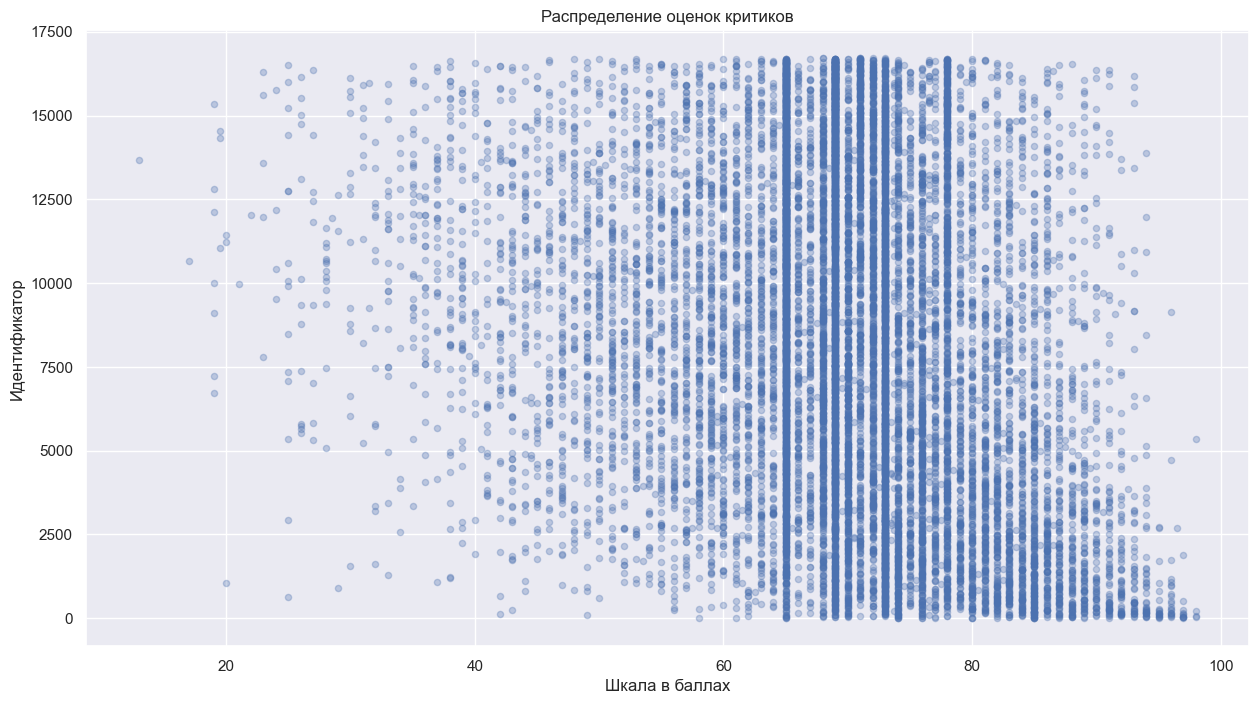

In [30]:
df.plot(x='critic_score', y='id', kind='scatter', alpha=0.3)
plt.title("Распределение оценок критиков")
plt.xlabel("Шкала в баллах")
plt.ylabel("Идентификатор")
plt.show()

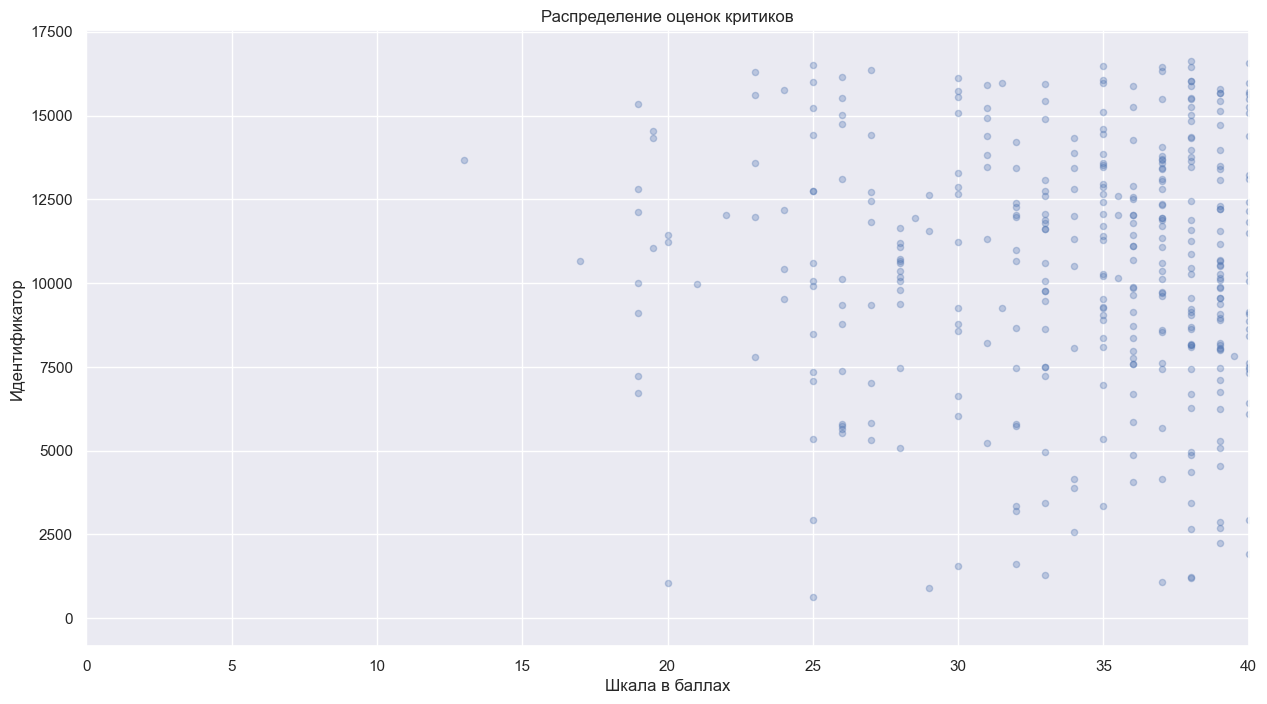

In [31]:
df.plot(x='critic_score', y='id', kind='scatter', alpha=0.3, xlim=[0,40])
plt.title("Распределение оценок критиков")
plt.xlabel("Шкала в баллах")
plt.ylabel("Идентификатор")
plt.show()

Примем за выбросы игры ниже 35 баллов, данные немногочисленные, ими можно пожертвовать:

In [32]:
df = df.drop(df.loc[df['critic_score'] < 35].index)

Далее изучим рейтинг пользователей:

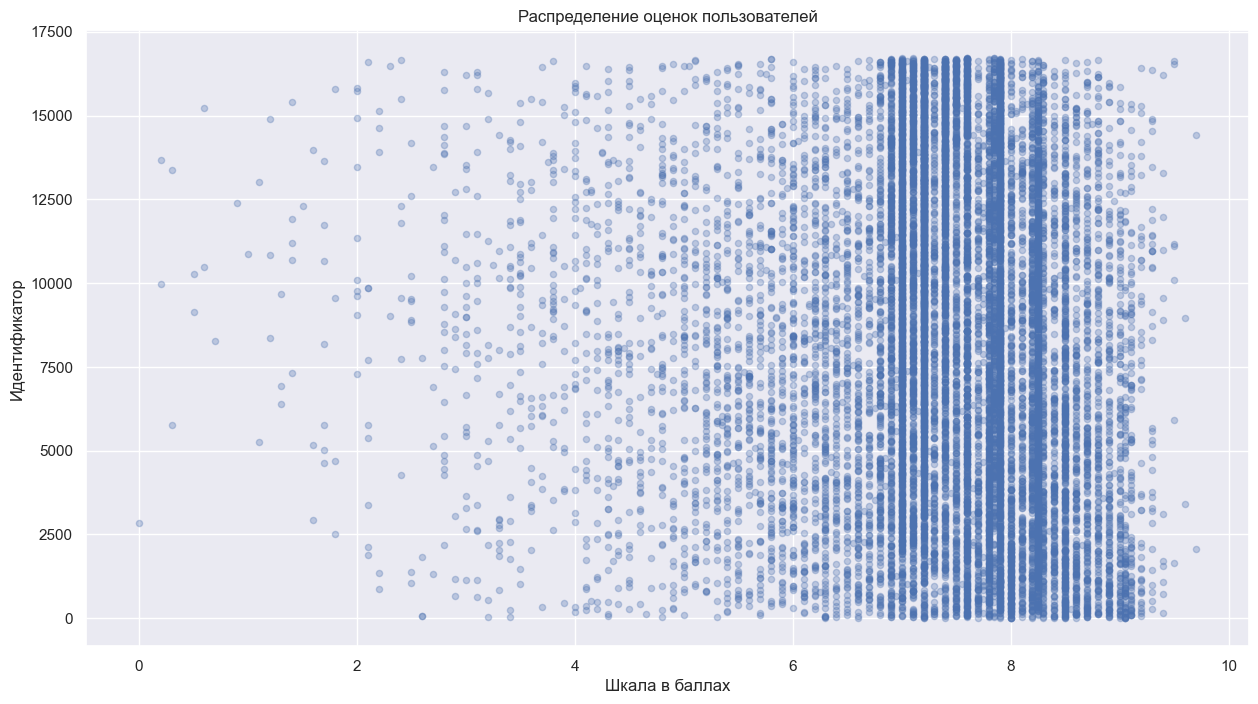

In [33]:
df.plot(x='user_score', y='id', kind='scatter', alpha=0.3)
plt.title("Распределение оценок пользователей")
plt.xlabel("Шкала в баллах")
plt.ylabel("Идентификатор")
plt.show()

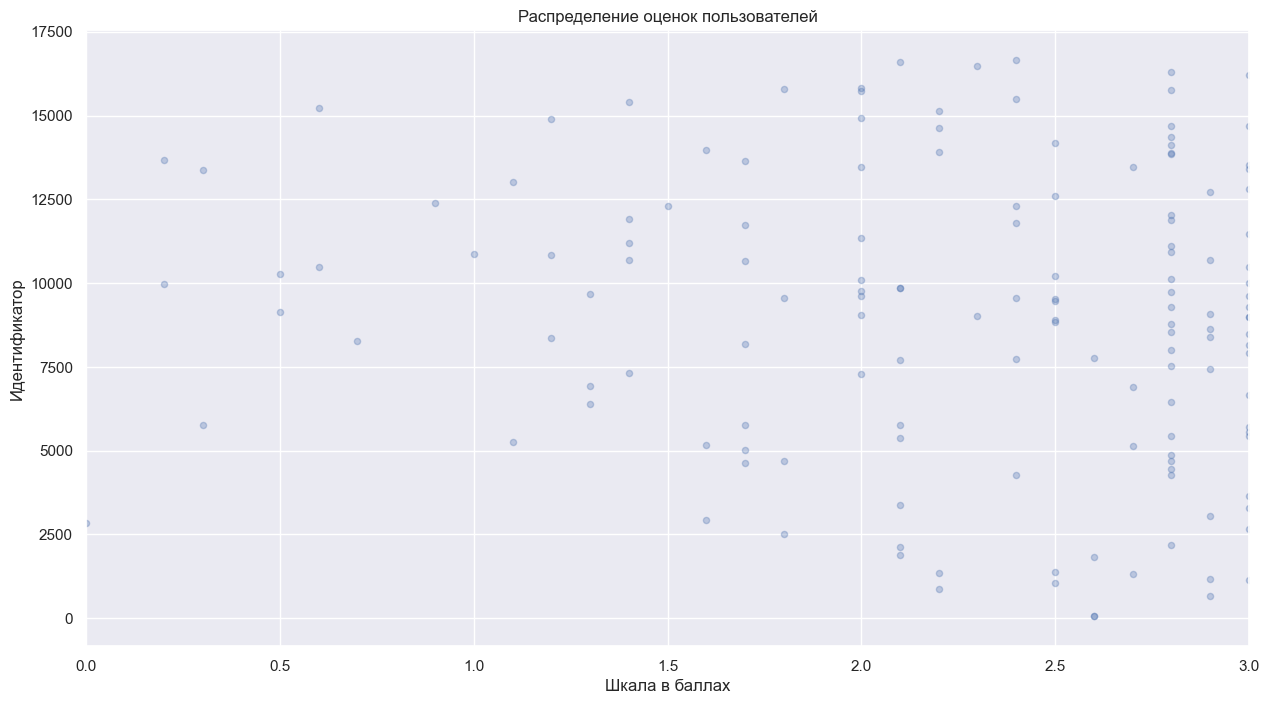

In [34]:
df.plot(x='user_score', y='id', kind='scatter', alpha=0.3, xlim=[0,3])
plt.title("Распределение оценок пользователей")
plt.xlabel("Шкала в баллах")
plt.ylabel("Идентификатор")
plt.show()

Здесь ситуация несколько сложнее, но в общем и целом можем наблюдать часть данных распределенную хаотично и сгруппированно, порог между этими данными находится между 2.7 и 2.8. Пожертвуем данными, расположенными слева от 2.8

In [35]:
df = df.drop(df.loc[df['user_score'] < 2.8].index)

Посмотрим что получилось:

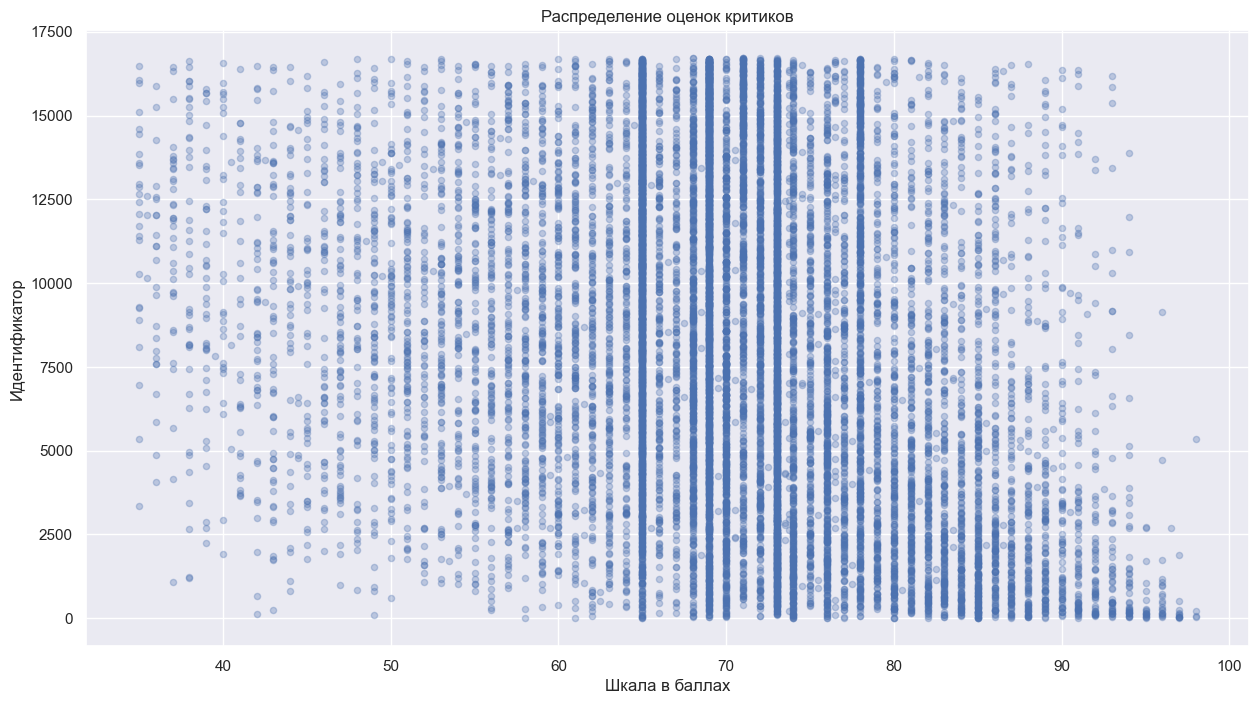

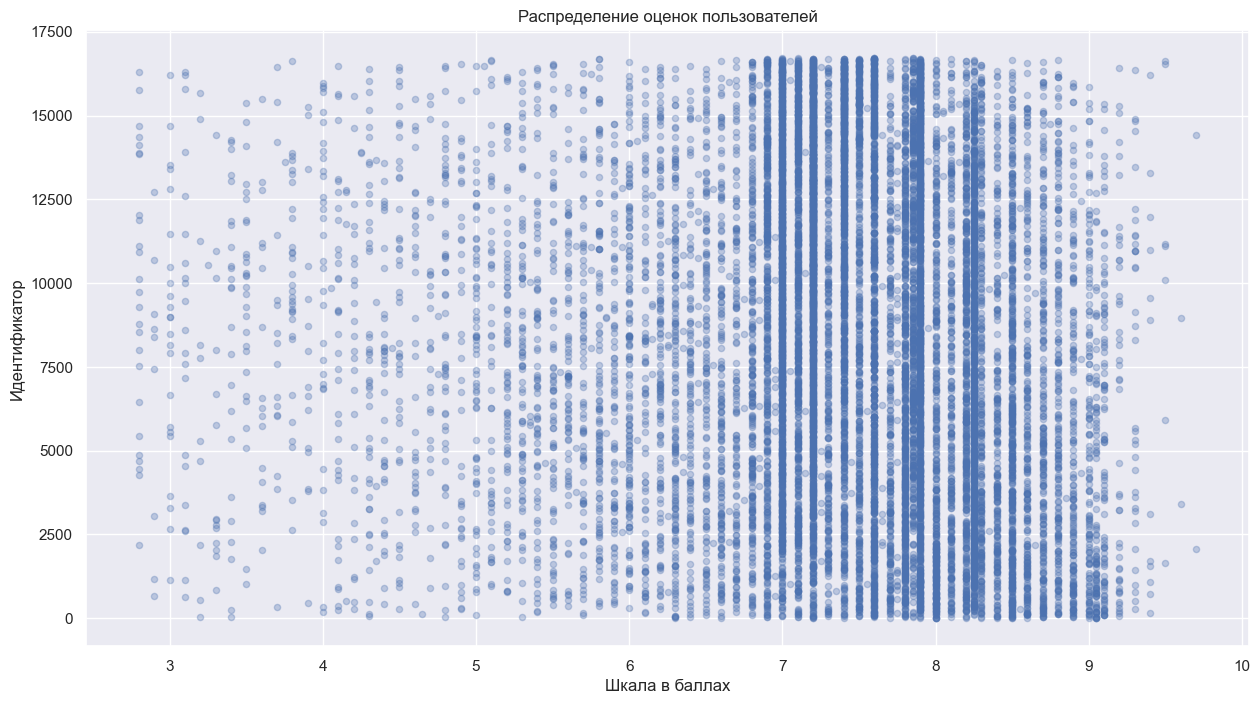

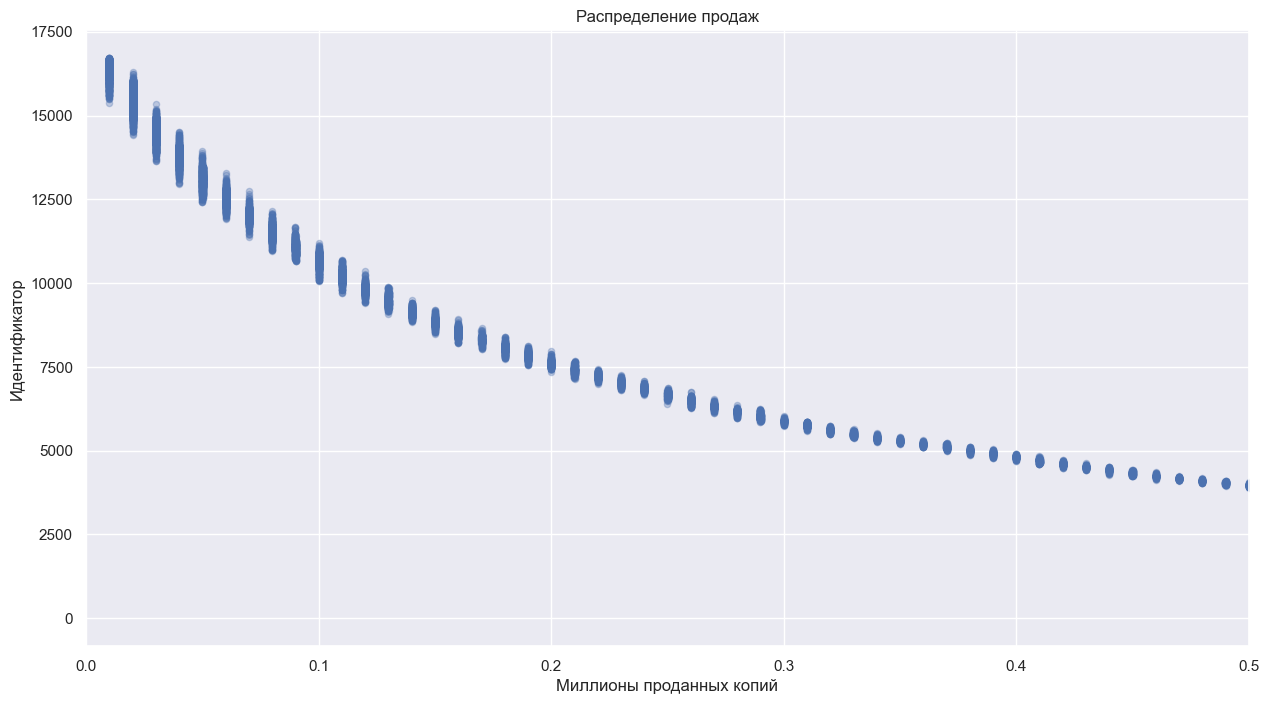

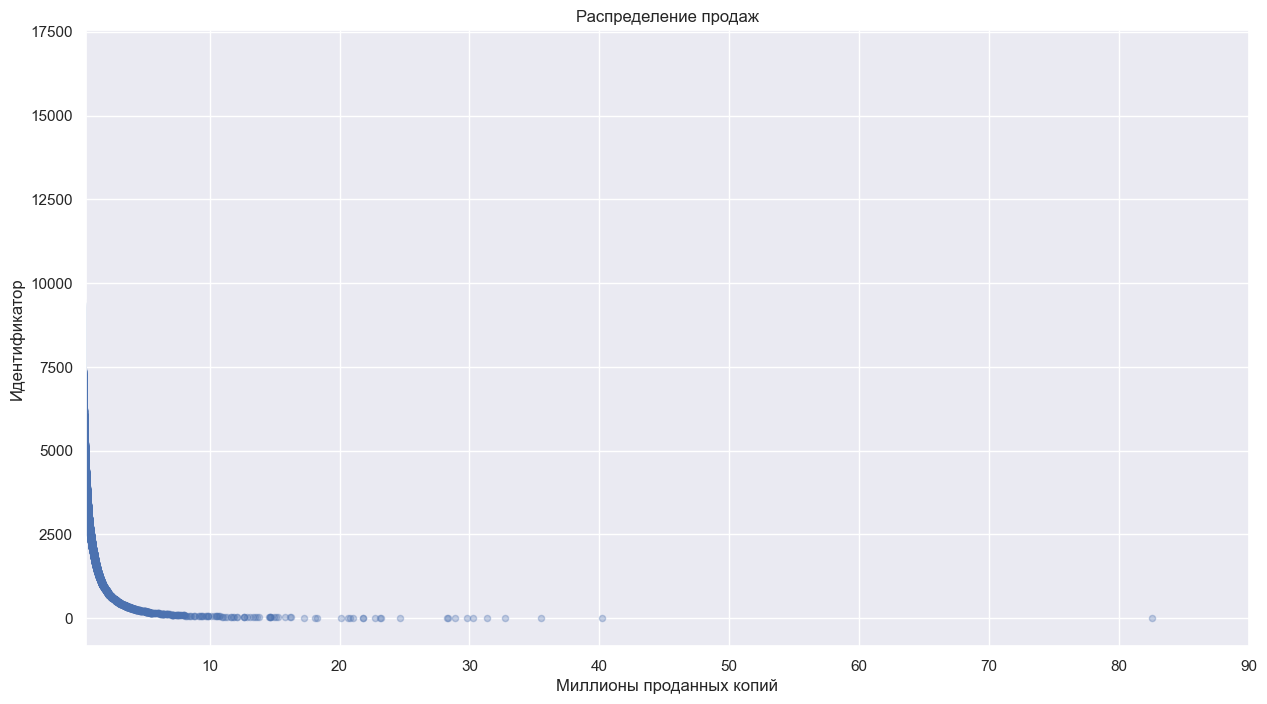

In [36]:
#скорректированное распределение рейтинга критиков:
df.plot(x='critic_score', y='id', kind='scatter', alpha=0.3)
plt.title("Распределение оценок критиков")
plt.xlabel("Шкала в баллах")
plt.ylabel("Идентификатор")

#скорректированное распределение рейтинга пользователей:
df.plot(x='user_score', y='id', kind='scatter', alpha=0.3)
plt.title("Распределение оценок пользователей")
plt.xlabel("Шкала в баллах")
plt.ylabel("Идентификатор")

#скорректированное распределение продаж до 0,5 млн.:
df.plot(x='total_sales', y='id', kind='scatter', alpha=0.3, xlim=[0, 0.5])
plt.title("Распределение продаж")
plt.xlabel("Миллионы проданных копий")
plt.ylabel("Идентификатор")

#скорректированное распределение продаж более 0,5 млн.:
df.plot(x='total_sales', y='id', kind='scatter', alpha=0.3, xlim=[0.5, 90])
plt.title("Распределение продаж")
plt.xlabel("Миллионы проданных копий")
plt.ylabel("Идентификатор")

plt.show()

In [37]:
df[df['total_sales'] > 80]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,id,total_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76.0,8.0,E,0,82.539993


А ведь "Wii Sports" действительно занимает почетное место среди лидеров продаж всех времен! (ru.wikipedia.org/wiki/Список_самых_продаваемых_компьютерных_игр)

Можем двигаться дальше.

Посчитаем долю удаленной информации в результате предварительной обработки:

In [38]:
removed = 1-df['name'].count()/df['id'].max()
print(f'По результатам предварительной обработки, доля отброшенных данных от общего объема составила: {removed:.1%}')

По результатам предварительной обработки, доля отброшенных данных от общего объема составила: 1.7%


#### Вывод:

В рамках предварительной обработки данных мы провели работу по изменению регистра столбцов, проверили датафрей на предмет явных и неявных дубликатов, устранили лишние пробелы в названии игр, а также провели работу по устранению пропусков и форматированию данных.

Также для дальнейшего использования при анализе данных мы рассчитали суммарное значение продаж каждой игры на каждой платформе.
Мы проанализировали данные на предмет аномальных значений и исключили из датафрейма игры без указания продаж, а также с нулевым и аномально низким рейтингом.

По результатам предварительной обработки доля данных от общего объема которыми мы пожертвовали составила 1,7%, считаем, что вполне приемлемо.

Наиболее чувствительным для нас оказалось отсутствие данных в колонках с информацией о пользовательском рейтинге и рейтинге критиков.
Причиной отсутствия указанных данных может быть технических сбой при формировании или хранении и передаче данных, отсутствие данной аналитики как таковой в период релиза игры, а также просто отсутствие оценок в том числе по играм, которые на момент формирования данной аналитики еще не были оценены пользователями в силу раннего релиза.

### Исследовательский анализ данных

Для упрощения процесса исследовательского анализа данных напишем функцию для построению гистаграммы по столбцу, диаграммы размаха и вывода описания параметра:

In [39]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating', 'id',
       'total_sales'],
      dtype='object')

In [40]:
# сделаем словарь для перевода названий колонок на русский
ru_names = [
    'Название игры',
    'Платформа',
    'Год релиза',
    'Жанр',
    'Продажи по региону Северная Америка',
    'Продажи по региону Европа',
    'Продажи по региону Япония',
    'Продажи по прочим регионам',
    'Оценка критиков',
    'Оценка пользователей',
    'Рейтинг ESRB',
    'Идентификатор',
    'Продажи итого'
]

ru_dict = dict(zip(df.columns, ru_names))

In [41]:
def research_data(data, col, xlabel, min_range, max_range, bins):
    df.hist(col, range=(min_range,max_range), bins=bins)
    plt.title(f'Гистограмма по показателю "{ru_dict[col]}"')
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.show()
    sns.boxplot(data=df[col], orient='h', linewidth = 1).set(
        ylabel=f'Диаграмма размаха \n по показателю "{ru_dict[col]}"\n',
        xlabel=xlabel
    )
    
    plt.show()
    display(df[col].describe())

#### Cтатистика выпущенных игр по годам

Посмотрим, сколько игр выпускалось в разные годы и важны ли для нас данные за все периоды.

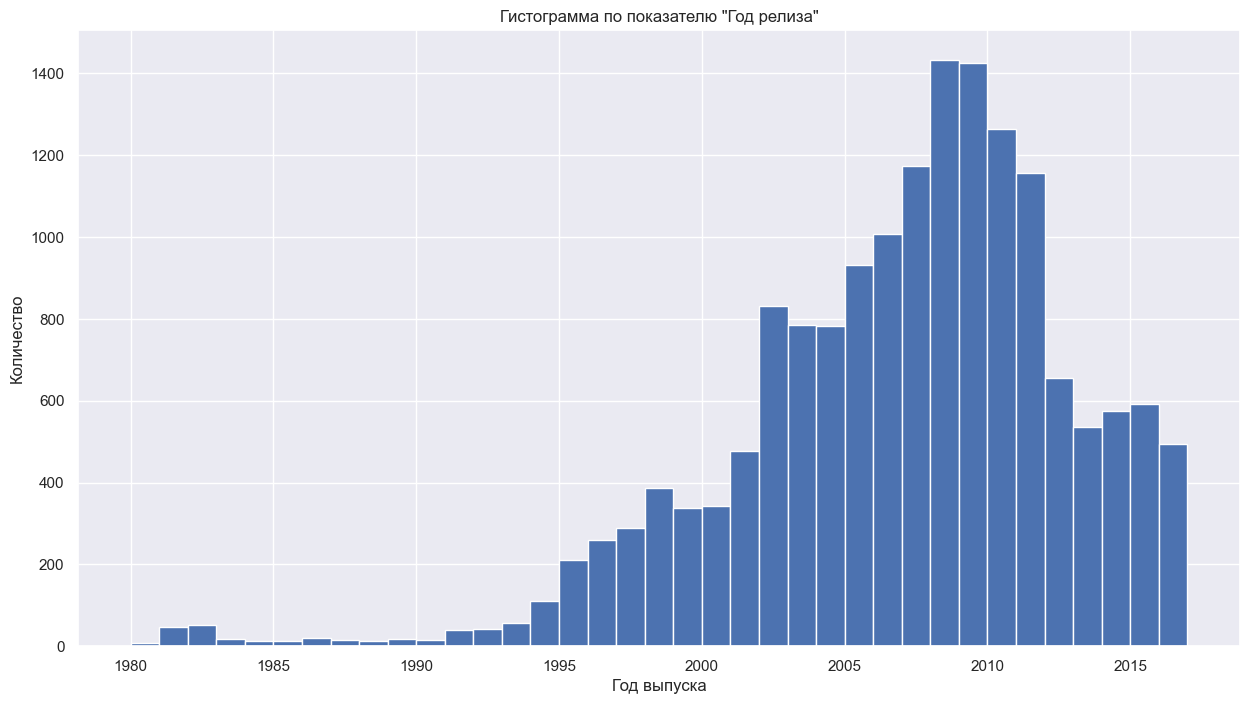

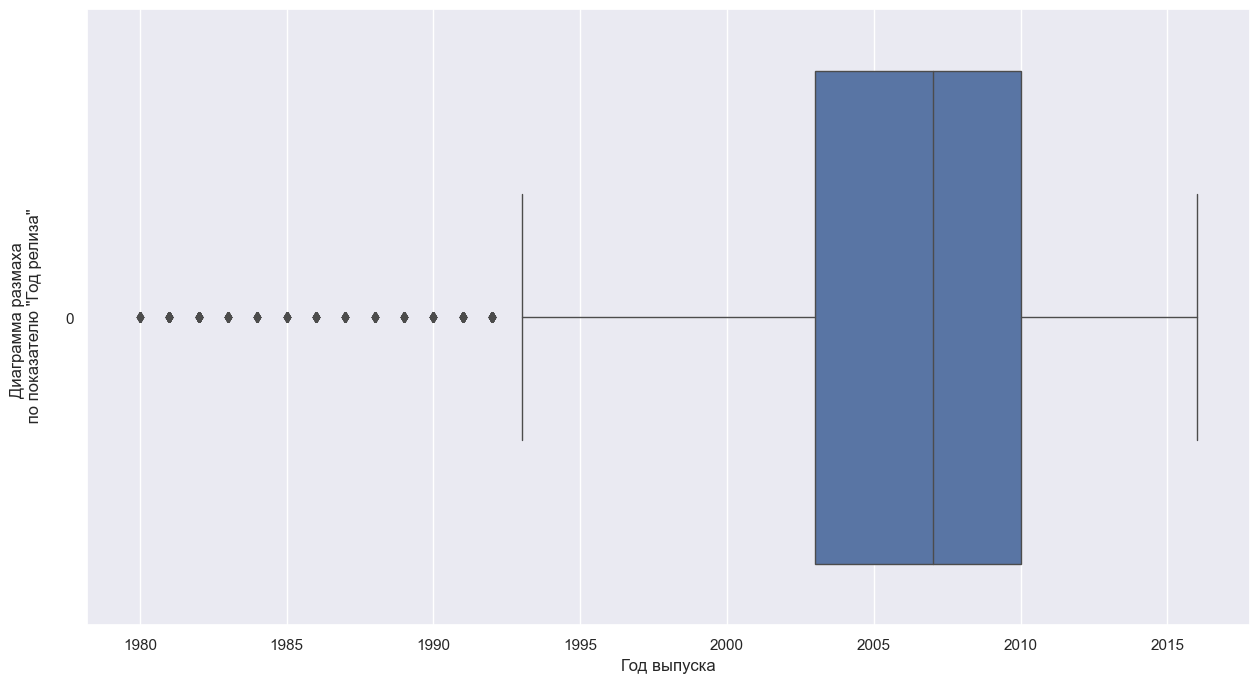

count    16436.000000
mean      2006.467754
std          5.897667
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

In [42]:
research_data(df, 'year_of_release', 'Год выпуска', 1980, 2017, 37)

Согласно диаграмме данные распределены следующим образом. С 1993 по 2016 (согласно диаграмме размаха) состредоточены ключевые данные по выпуску игр. Данные с 1980 по 1992 год можно считать формальными выбросами, поскольку количество игр, выпускаемых в этот период не сопоставимо с количеством игр выпускаемых с середины 2000х и вплоть до 2016 года.
Медианное значение фиксирует 2007 год, пик выпуска игр пришелся на 2008-2009 года.
Также необходимо отметить 2002 год, именно тогда произошел практически кратный рост релизов, что ознаменовало, можно сказать, "золотое" десятилетие игровой индустрии.

#### Динамика продаж по платформам

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Также посмотрим за какой характерный срок появляются новые и исчезают старые платформы.

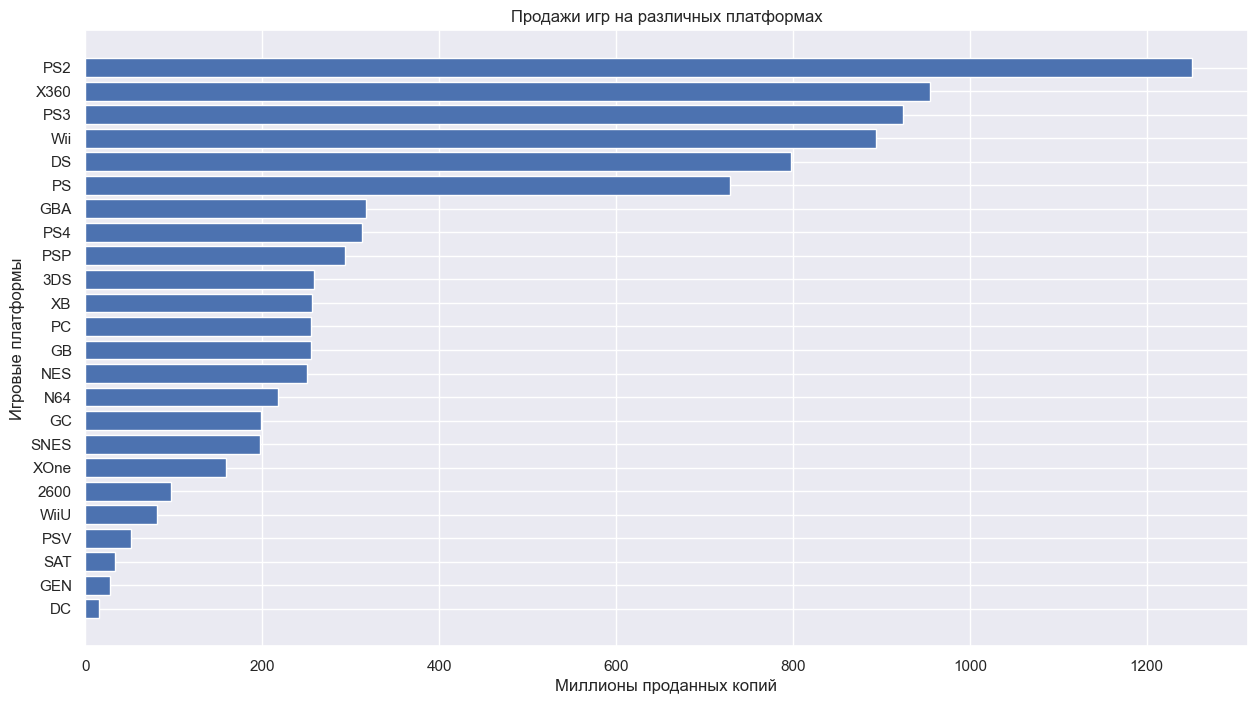

In [43]:
platform_sales = df.groupby(['platform'])['total_sales'].sum().sort_values(ascending=True)
plt.barh(
    platform_sales.index,
    platform_sales.values
)
plt.title("Продажи игр на различных платформах")
plt.xlabel("Миллионы проданных копий")
plt.ylabel("Игровые платформы")
plt.show()

Среди безоговорочных лидеров: PS2, X360, PS3, Wii, DS, PS. Также включим PS4, XOne и PC как следующие поколения консолей для наглядности. Построим распределение по годам.

Создадим датасет из выбранных платформ:

In [44]:
top_pf_sales = df.loc[
    (df['platform'] == 'Wii')|
    (df['platform'] == 'DS')|
    (df['platform'] == 'X360')|
    (df['platform'] == 'PS3')|
    (df['platform'] == 'PS2')|
    (df['platform'] == 'PS')|
    (df['platform'] == 'PS4')|
    (df['platform'] == 'XOne')|
    (df['platform'] == 'PC')
]

Сведем таблицу по платформам с выручкой по годам:

In [45]:
top_pf_sales_pivot = top_pf_sales.pivot_table(
    index = ['year_of_release'],
    columns = ['platform'],
    values = ['total_sales'],
    aggfunc = 'sum')
top_pf_sales_pivot.columns = ['DS', 'PC', 'PS', 'PS2', 'PS3', 'PS4', 'Wii', 'X360', 'XOne']
top_pf_sales_pivot

,DS,PC,PS,PS2,PS3,PS4,Wii,X360,XOne
year_of_release,,,,,,,,,
1985,0.020000,0.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NaN,3.030000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,NaN,12.870000,6.030000,NaN,NaN,NaN,NaN,NaN,NaN
1995,NaN,4.220000,35.959999,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,10.580000,94.700005,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,11.270000,136.169998,NaN,NaN,NaN,NaN,NaN,NaN
1998,NaN,3.260000,172.770004,NaN,NaN,NaN,NaN,NaN,NaN
1999,NaN,4.740000,144.529999,NaN,NaN,NaN,NaN,NaN,NaN
2000,NaN,4.660000,95.540001,39.170002,NaN,NaN,NaN,NaN,NaN


Нарисуем графики. Поскольку данные за 2016 год могут быть неполными, примем к сведению данные за 2016 год по новым платформам как не отражающие тренд следующих лет:

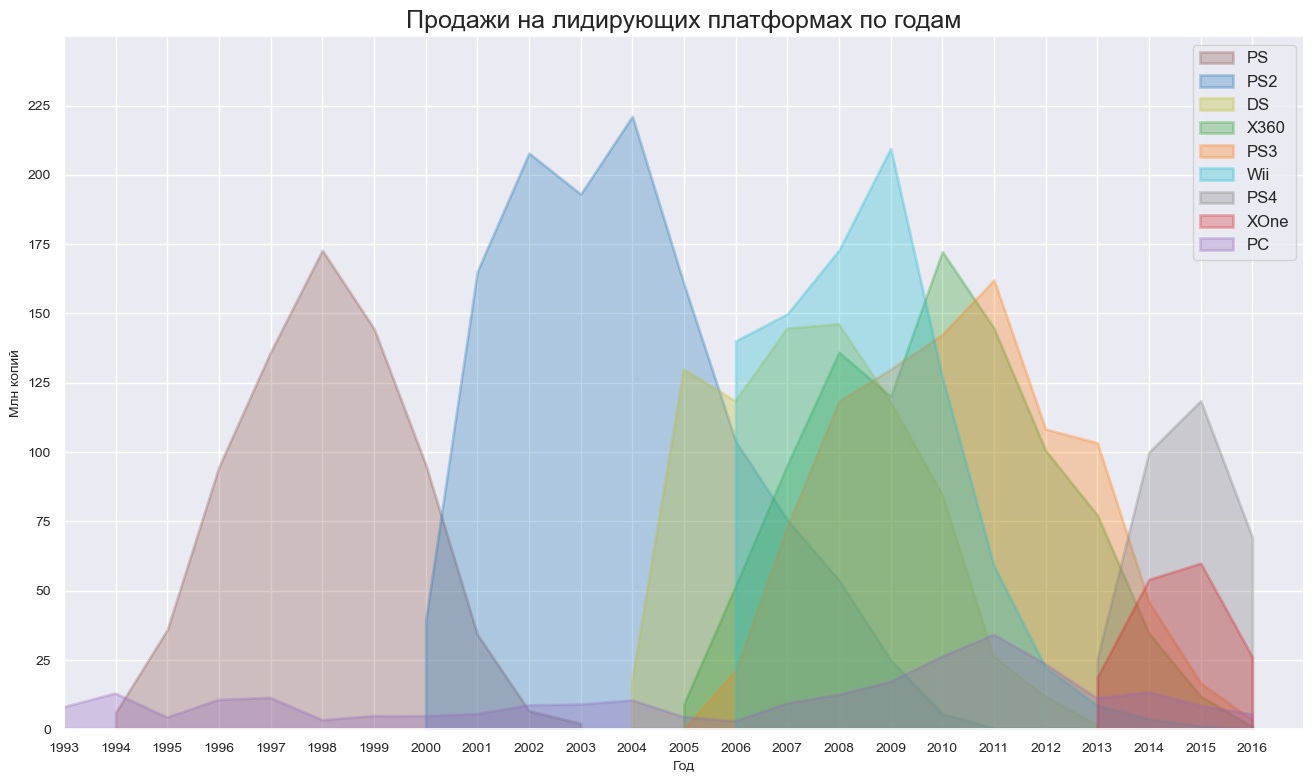

In [46]:
x  = top_pf_sales_pivot.index.values.tolist()
y0 = top_pf_sales_pivot['DS'].values.tolist()
y1 = top_pf_sales_pivot['PC'].values.tolist()
y2 = top_pf_sales_pivot['PS'].values.tolist()
y3 = top_pf_sales_pivot['PS2'].values.tolist()
y4 = top_pf_sales_pivot['PS3'].values.tolist()
y5 = top_pf_sales_pivot['PS4'].values.tolist()
y6 = top_pf_sales_pivot['Wii'].values.tolist()
y7 = top_pf_sales_pivot['X360'].values.tolist()
y8 = top_pf_sales_pivot['XOne'].values.tolist()
mycolors = ['tab:olive','tab:purple', 'tab:brown', 'tab:blue', 'tab:orange', 'tab:grey', 'tab:cyan', 'tab:green', 'tab:red']      
columns = ['DS', 'PC', 'PS', 'PS2', 'PS3', 'PS4', 'Wii', 'X360', 'XOne']

fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi= 100)
ax.fill_between(x, y1=y2, label=columns[2], alpha=0.3, color=mycolors[2], linewidth=2)
ax.fill_between(x, y1=y3, label=columns[3], alpha=0.3, color=mycolors[3], linewidth=2)
ax.fill_between(x, y1=y0, label=columns[0], alpha=0.3, color=mycolors[0], linewidth=2)
ax.fill_between(x, y1=y7, label=columns[7], alpha=0.3, color=mycolors[7], linewidth=2)
ax.fill_between(x, y1=y4, label=columns[4], alpha=0.3, color=mycolors[4], linewidth=2)

ax.fill_between(x, y1=y6, label=columns[6], alpha=0.3, color=mycolors[6], linewidth=2)


ax.fill_between(x, y1=y5, label=columns[5], alpha=0.3, color=mycolors[5], linewidth=2)


ax.fill_between(x, y1=y8, label=columns[8], alpha=0.3, color=mycolors[8], linewidth=2)
ax.fill_between(x, y1=y1, label=columns[1], alpha=0.3, color=mycolors[1], linewidth=2)

ax.set_title('Продажи на лидирующих платформах по годам', fontsize=18)
ax.set(ylim=[0, 250])
ax.legend(loc='best', fontsize=12)
plt.xticks(np.arange(1993, 2017, 1), fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(0, 250, 25), fontsize=10)
plt.xlim(1993, 2017)
plt.xlabel('Год', fontsize=10)
plt.ylabel('Млн копий', fontsize=10)

plt.show()

Если внимательно рассмотреть динамику продаж на выбранных платформах, можно заметить, что жизненный цикл платформ ограничен 10 годами (+/- 1 год). При этом отмечаем, что конкурентам требуется все меньше времени, чтобы навязать конкуренцию платформам, набирающим популярность. Так преобладающую популярность PS2 уже на четвертый год потеснила DS, спустя год долю рынка отвоевала X360, а еще через год Wii буквально за год сумела потеснить всех имеющихся на тот момент конкурентов.

#### Динамика продаж 2014-2015

Актуальные данные для прогноза возьмем за 2014-2015 год, 2016 год может быть неполным, опираться на него при прогнозе может быть опрометчиво. Среди актуальных платформ в этот период имеем: Wii, PC, X360, PS3, XOne, PS4  

In [47]:
forecast_period = top_pf_sales_pivot.query('year_of_release == [2014, 2015, 2016]') 
forecast_period

,DS,PC,PS,PS2,PS3,PS4,Wii,X360,XOne
year_of_release,,,,,,,,,
2014,NaN,13.26,NaN,NaN,45.939999,100.000000,3.75,34.66,54.070000
2015,NaN,8.39,NaN,NaN,16.670000,118.519997,1.14,11.90,59.910000
2016,NaN,5.27,NaN,NaN,3.370000,69.209999,0.18,0.96,26.120001


Как и предполагали, данные 2016 года не полные, учтем это в дальнейшем анализе

Построим график:

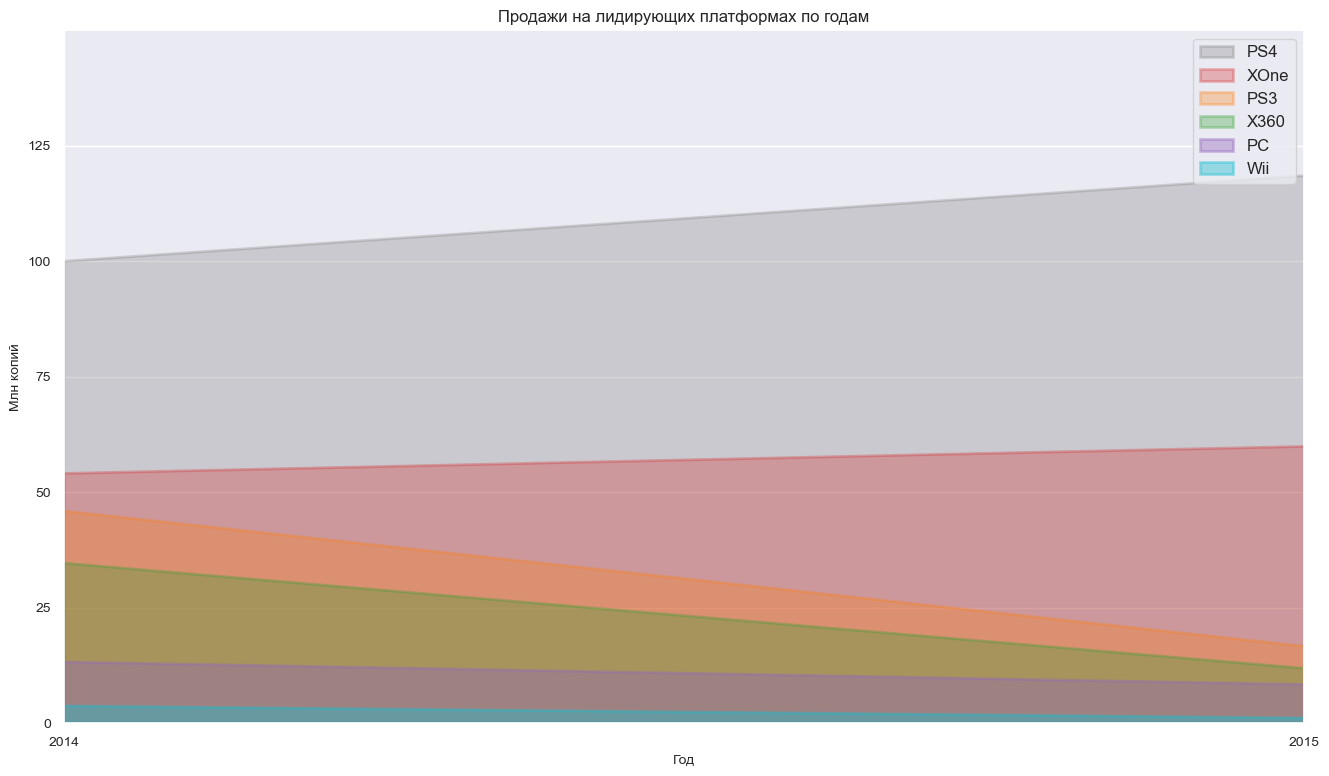

In [48]:
xx  = forecast_period.index.values.tolist()
yy1 = forecast_period['PC'].values.tolist()
yy4 = forecast_period['PS3'].values.tolist()
yy5 = forecast_period['PS4'].values.tolist()
yy6 = forecast_period['Wii'].values.tolist()
yy7 = forecast_period['X360'].values.tolist()
yy8 = forecast_period['XOne'].values.tolist()
mycolors = ['tab:olive','tab:purple', 'tab:brown', 'tab:blue', 'tab:orange', 'tab:grey', 'tab:cyan', 'tab:green', 'tab:red']      
columns = ['DS', 'PC', 'PS', 'PS2', 'PS3', 'PS4', 'Wii', 'X360', 'XOne']

fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi= 100)
ax.fill_between(xx, y1=yy5, label=columns[5], alpha=0.3, color=mycolors[5], linewidth=2)
ax.fill_between(xx, y1=yy8, label=columns[8], alpha=0.3, color=mycolors[8], linewidth=2)
ax.fill_between(xx, y1=yy4, label=columns[4], alpha=0.3, color=mycolors[4], linewidth=2)
ax.fill_between(xx, y1=yy7, label=columns[7], alpha=0.3, color=mycolors[7], linewidth=2)
ax.fill_between(xx, y1=yy1, label=columns[1], alpha=0.4, color=mycolors[1], linewidth=2)
ax.fill_between(xx, y1=yy6, label=columns[6], alpha=0.4, color=mycolors[6], linewidth=2)

ax.set_title('Продажи на лидирующих платформах по годам', fontsize=12)
ax.set(ylim=[0, 150])
ax.legend(loc='best', fontsize=12)
plt.xticks(np.arange(2014, 2015.1, 1), fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(0, 150, 25), fontsize=10)
plt.xlim(2014, 2015)
plt.xlabel('Год', fontsize=10)
plt.ylabel('Млн копий', fontsize=10)

plt.show()

2016 год лучше не показывать, искажается картинка восприятия. В целом по 2014-2015 годам можно сделать справедливые выводы, на наш взгляд, как в отношении динамики платформ 2016 года и прогноза 2017.

#### Выбор потенциально прибыльных платформ

Исходя из имеющихся данных можно сказать что PS4, которая является преемником PS3, стремительно завоевывает популярность. Конкурирующая платформа от Microsoft XOne также показывает положительную динамику, однако не такую впечатляющую как продукты от Sony. При этом, PS3 как и X360 уступают долю рынка новому поколению консолей, что выглядит вполне логично. Что же касается PC и Wii данные платформы постепенно теряют пользователей, но в связи с отсутствием прямых конкурентов данных платформы продолжают приносить стабильный доход.

В части прибыльности, безусловно платформа от Sony (PS4) и ее прямой конкурент от Microsoft (XOne) будут наращивать аудиторию, и увеличивать свою прибыльность в перспективе 2-3 лет до момента выпуска нового поколения данных консолей.

#### «Ящик с усами» и платформы с продажами

Построим диаграмму размаха по суммарным продажам в разрезе платформ.

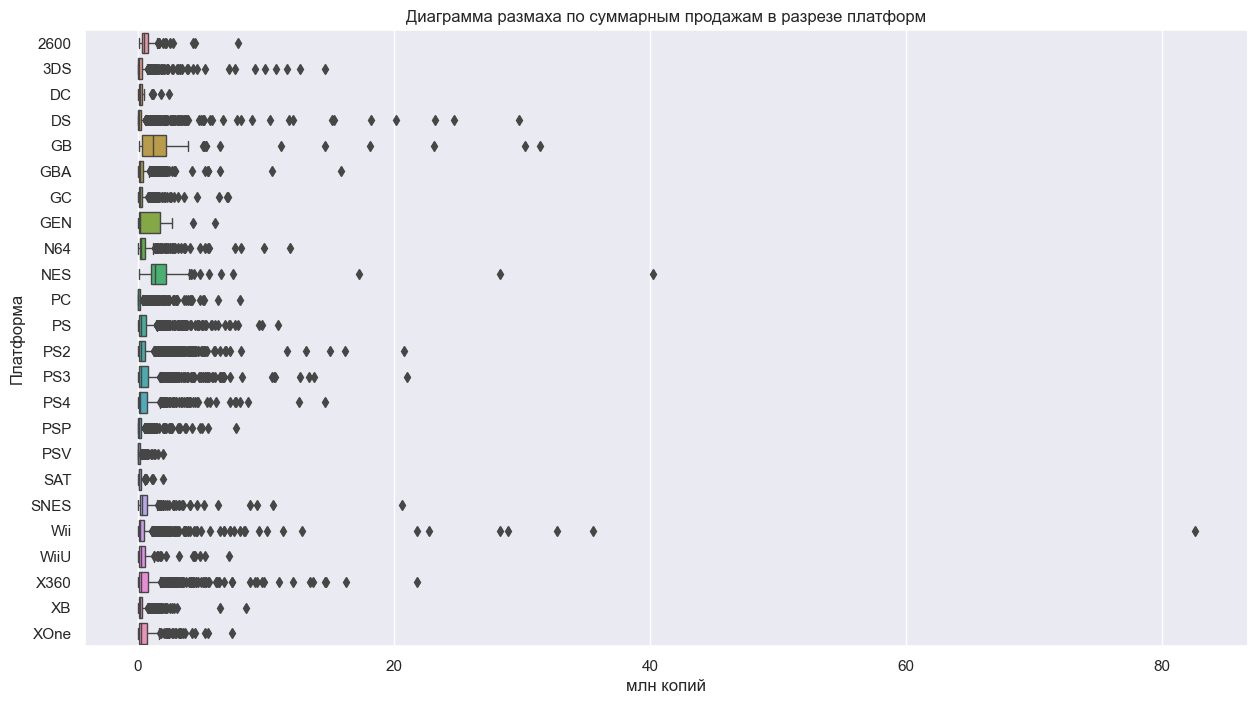

In [49]:
platform_pivot = df.pivot_table(
 index ='id',
    columns='platform',
    values ='total_sales',
    aggfunc = 'sum'
)

sns.boxplot(data=platform_pivot, orient='h', linewidth = 1).set(
    xlabel='млн копий',
    ylabel='Платформа',
    title='Диаграмма размаха по суммарным продажам в разрезе платформ'
)

plt.show()

Для анализа данных отбросим часть выбросов. Наиболее плотно данные организованы ниже 10 млн копий, установим значение 6 млн.

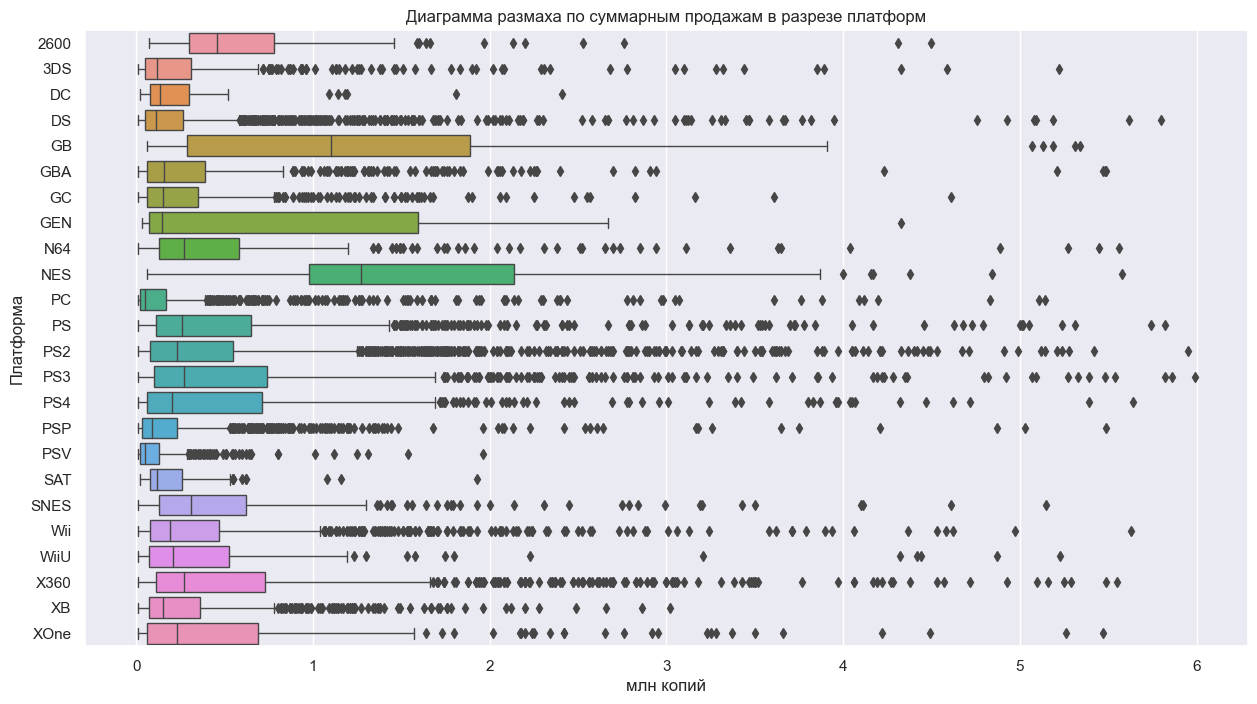

In [50]:
platform_cut_data = df.loc[df['total_sales'] < 6]
platform_pivot_cut = platform_cut_data.pivot_table(
 index ='id',
    columns='platform',
    values ='total_sales',
    aggfunc = 'sum'
)
sns.boxplot(data=platform_pivot_cut, orient='h', linewidth = 1).set(
    xlabel='млн копий',
    ylabel='Платформа',
    title='Диаграмма размаха по суммарным продажам в разрезе платформ'
)

plt.show()

На диаграмме размаха наглядно изображена платформенная специфика в контексте распределения значений продаж. Чем чаще релизы тем ниже медианное значение, чем реже выходят платформенные новинки тем медианное значение выше, все достаточно логично.
К примеру, игры на PS охватывают по сути одну и ту же пользовательскую базу с  аналогичными ценовыми параметрами, что позволяет сохранить средние продажи по игре примерно на одном уровне, выход игр на данные платформы также достаточно регулярен.
Аналогичный вывод можно сделать по платформам X360, XOne, которые являлись и являются основными конкурентами PS.
Такие платформы как SNES, N64, Wii и WiiU также ориентированы на один и тот же сегмент, по сути говоря, ценовые параметры игр, а также частота их релизов определяет медиану по сегменту.

Ситуация по NES, GEN и GB, схожая. По сути своей нишевые платформы, с длительным жизненным циклом, долгое время не имеющие значительного количества конкурентов, имели возможность продавать одни и те же игры игры долгое время и тем самым увеличивая медианное значение продажи.

#### Корреляция продаж и рейтингов

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Для этих целей возьмем платформу PS4, построим по ней диаграмму рассеяния по отзывам пользователей и критиков.

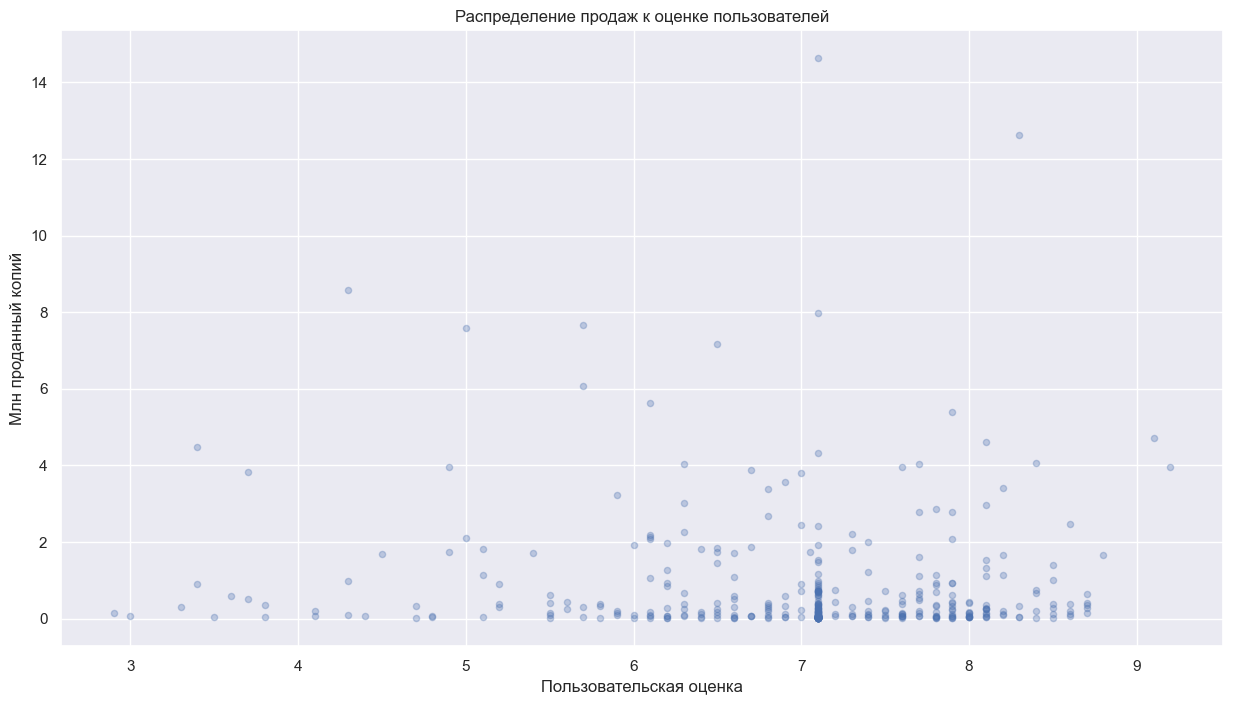

In [51]:
ps_four_data = df[df['platform'] =='PS4']
ps_four_data.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, grid=True)
plt.title("Распределение продаж к оценке пользователей")
plt.xlabel("Пользовательская оценка")
plt.ylabel("Млн проданный копий")
plt.show()

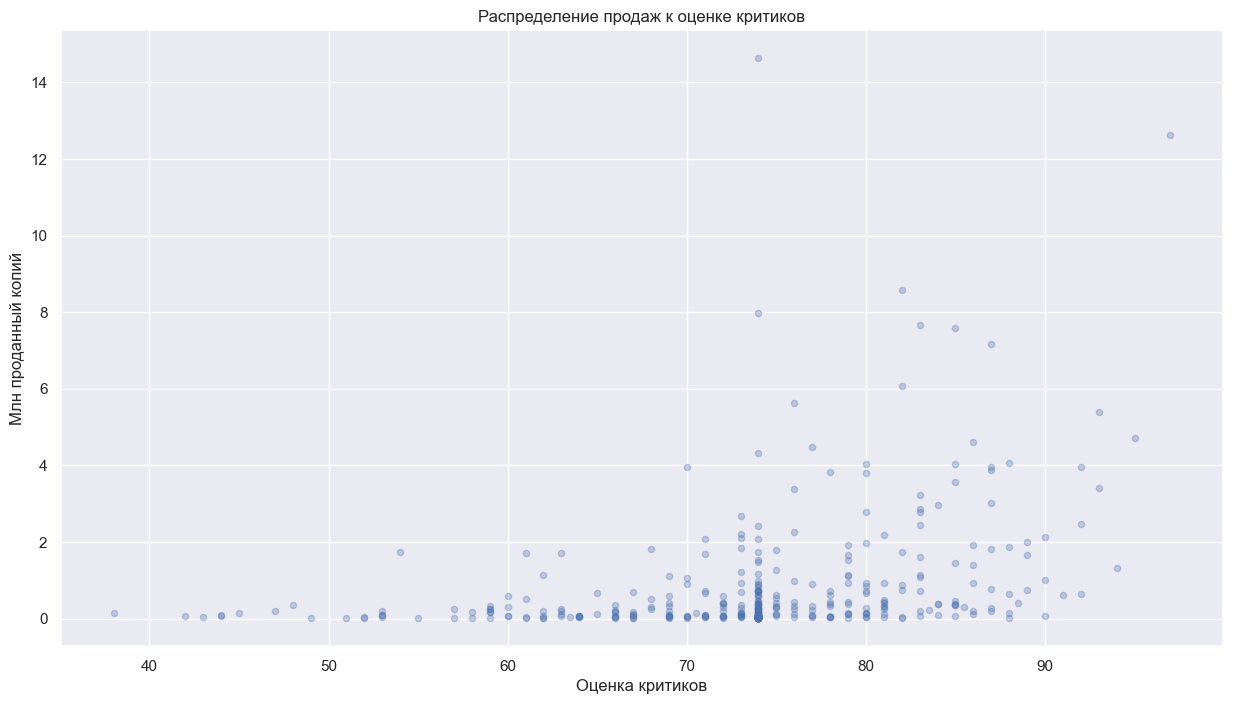

In [52]:
ps_four_data = df[df['platform'] =='PS4']
ps_four_data.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, grid=True)
plt.title("Распределение продаж к оценке критиков")
plt.xlabel("Оценка критиков")
plt.ylabel("Млн проданный копий")
plt.show()

Можно заметить, что количество продаж растет с ростом рейтингов, проверим данную информацию путем расчета коэффициента корреляции.

In [53]:
def corr (pltfrm):
    pltfrm_data = df[df['platform'] == pltfrm]
    display(f'Таблица корреляции по {pltfrm}:',
            pltfrm_data[['critic_score','user_score','total_sales']].corr())
    print()

In [54]:
corr('PS4')

'Таблица корреляции по PS4:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.423099,0.337473
user_score,0.423099,1.000000,-0.069769
total_sales,0.337473,-0.069769,1.000000


Как показывает анализ корреляции, наши предположения подтвердились лишь отчасти, имеется незначительная прямая взаимосвязь с оценкой критиков, пользовательский рейтинг на продажи практически не влияет.

Соотнесем выводы с продажами игр на других платформах:

In [55]:
corr('PS')
corr('PS2')
corr('PS3')
corr('X360')
corr('XOne')
corr('DS')
corr('PC')
corr('Wii')
corr('NES')
corr('GB')
corr('GEN')

'Таблица корреляции по PS:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.432253,0.325721
user_score,0.432253,1.000000,0.139118
total_sales,0.325721,0.139118,1.000000


'Таблица корреляции по PS2:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.472501,0.366978
user_score,0.472501,1.000000,0.132804
total_sales,0.366978,0.132804,1.000000


'Таблица корреляции по PS3:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.507871,0.384621
user_score,0.507871,1.000000,0.101856
total_sales,0.384621,0.101856,1.000000


'Таблица корреляции по X360:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.475268,0.366433
user_score,0.475268,1.000000,0.102797
total_sales,0.366433,0.102797,1.000000


'Таблица корреляции по XOne:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.367053,0.324677
user_score,0.367053,1.000000,-0.134504
total_sales,0.324677,-0.134504,1.000000


'Таблица корреляции по DS:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.441644,0.183962
user_score,0.441644,1.000000,0.095458
total_sales,0.183962,0.095458,1.000000


'Таблица корреляции по PC:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.531644,0.201717
user_score,0.531644,1.000000,0.004017
total_sales,0.201717,0.004017,1.000000


'Таблица корреляции по Wii:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.502049,0.162241
user_score,0.502049,1.000000,0.099697
total_sales,0.162241,0.099697,1.000000


'Таблица корреляции по NES:'

,critic_score,user_score,total_sales
critic_score,1.000000,-0.478817,-0.035793
user_score,-0.478817,1.000000,0.042118
total_sales,-0.035793,0.042118,1.000000


'Таблица корреляции по GB:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.955514,-0.006985
user_score,0.955514,1.000000,0.003658
total_sales,-0.006985,0.003658,1.000000


'Таблица корреляции по GEN:'

,critic_score,user_score,total_sales
critic_score,1.000000,0.974477,-0.323506
user_score,0.974477,1.000000,-0.400381
total_sales,-0.323506,-0.400381,1.000000


По большинству из рассматриваемых выше платформам корреляция аналогична PS4. По таким платформам как NES и GB корреляция вовсе отсуствует, возможно просто потому, что на момент выхода игр на этой платформе оценки и критиков и игроков для пользователей были недоступны из-за отсутствия интернета. С GEN ситуация еще интереснее, корреляция есть, слабая, но обратная, чем выше рейтинг тем ниже продажи, интернета также небыло, возможно это связано с недоверием оценок, либо просто с высокой ценой на популярные у критиков и у пользователей игры, дешевле-популярнее.

#### Жанры, игры и продажи

Посмотрим на общее распределение игр по жанрам:

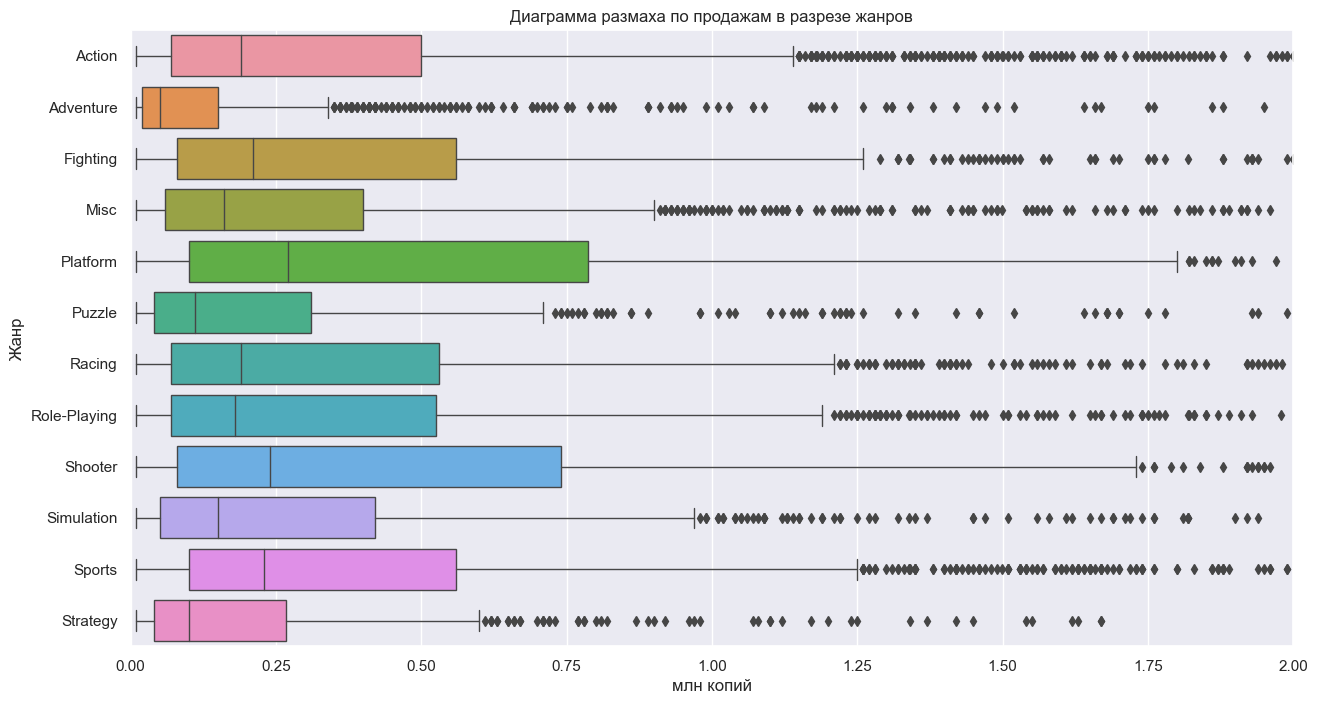

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
count,3313.000000,1288.000000,826.000000,1721.000000,878.000000,571.000000,1223.000000,1491.000000,1289.000000,859.000000,2303.000000,674.000000
mean,0.523794,0.182104,0.537639,0.460017,0.938838,0.422907,0.591832,0.625909,0.796881,0.446810,0.574212,0.256231
std,1.153936,0.510952,0.963142,1.313192,2.587784,1.574249,1.672585,1.713890,1.802250,1.193748,2.104008,0.522154
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.070000,0.020000,0.080000,0.060000,0.100000,0.040000,0.070000,0.070000,0.080000,0.050000,0.100000,0.040000
50%,0.190000,0.050000,0.210000,0.160000,0.270000,0.110000,0.190000,0.180000,0.240000,0.150000,0.230000,0.100000
75%,0.500000,0.150000,0.560000,0.400000,0.787500,0.310000,0.530000,0.525000,0.740000,0.420000,0.560000,0.267500
max,21.049999,11.179999,12.840000,28.910000,40.240002,30.260000,35.520000,31.380001,28.309999,24.670000,82.539993,5.450000


In [56]:
genre_sales = df.pivot_table(
    index ='id',
    columns='genre',
    values ='total_sales',
    aggfunc = 'sum'
)

sns.boxplot(data=genre_sales, orient='h', linewidth = 1).set(
    xlabel='млн копий',
    ylabel='Жанр',
    title='Диаграмма размаха по продажам в разрезе жанров'
)
plt.xlim([0,2])
plt.show()
genre_sales.describe()

Лидером среди жанров являются Platform-игры, согласно медианному значению, каждая Platform-игра продается тиражом в 270 тыс. копий. На втором месте Shooter, на третьем Sports, а вот Puzzle, Strategy и Adventure пользуются наименьшей популярностью. Что удивительно, безусловный лидер по количеству игр, жанр Action, по медианному значению продается тиражом 190 тыс копий, а ведь это столько же сколько у жанра Racing, у которого общее количество игр более чем в 2,5 раз меньше чем в жанре Action.

#### Вывод:

Итак, по результатам исследовательского анализа данных мы выяснили, что количество игр, выпускаемых с 1980 по 1992 год не сопоставимо с количеством игр выпускаемых с середины 2000х и вплоть до 2016 года, пик выпуска игр пришелся на 2008-2009 года. 

В среднем, жизненный цикл платформ ограничен примерно 10 годами, при этом, с каждым годом конкурентам требуется все меньше времени, чтобы навязать конкуренцию платформам, набирающим популярность. Так преобладающую популярность PS2 уже на четвертый год потеснила DS, спустя год долю рынка отвоевала X360, а еще через год Wii буквально за год сумела потеснить всех имеющихся на тот момент конкурентов.

В части прибыльности, безусловно платформа от Sony (PS4) и ее прямой конкурент от Microsoft (XOne) будут наращивать аудиторию, и увеличивать свою прибыльность в перспективе 2-3 лет до момента выпуска нового поколения данных консолей.

Продажи на каждой из платформ имеют свою специфику, а именно чем чаще релизы тем ниже медианное значение, чем реже выходят платформенные новинки тем медианное значение продаж выше. 

По большинству из рассматриваемых платформам корреляция между продажами и рейтингом либо слабо положительная, либо вовсе отсутствует. Такое возможно просто потому, что на момент выхода игр на некоторых платформах оценки и критиков и игроков для пользователей были недоступны из-за отсутствия интернета.

Лидером среди жанров являются Platform-игры. Согласно медианному значению, каждая Platform-игра продается тиражом в 270 тыс. копий. На втором месте Shooter, на третьем Sports, а вот Puzzle, Strategy и Adventure пользуются наименьшей популярностью.

### Портрет пользователя

Определим портрет пользователя каждого региона (NA, EU, JP):

Упростим себе жизнь функцией:


In [57]:
def portrait(col):
    df_portrait = df.loc[df[col]> 0]
    
    # Здесь мы строим гистограмму по продажам в разрезе жанров
    portrait_gen_grouped = df_portrait.groupby(
        ['genre'])['total_sales'].median().sort_values(ascending=True)
    plt.barh(
        portrait_gen_grouped.index,
        portrait_gen_grouped.values
    )
    plt.title("Продажи по жанрам")
    plt.xlabel("Млн проданных копий")
    plt.ylabel("Игровые жанры")
    plt.show()
    
    # Здесь мы строим гистограмму по продажам в разрезе платформ
    portrait_plt_grouped = df_portrait.groupby(
        ['platform'])['total_sales'].sum().sort_values(ascending=True)
    plt.barh(
        portrait_plt_grouped.index,
        portrait_plt_grouped.values
    )
    plt.title("Продажи по платформам")
    plt.xlabel("Млн проданных копий")
    plt.ylabel("Игровые платформы")
    plt.show()
    
    # Здесь мы строим гистограмму по продажам в разрезе рейтинга ESRB
    portrait_esrb_grouped = df_portrait.groupby(
        ['rating'])['total_sales'].sum().sort_values(ascending=True)
    plt.barh(
        portrait_esrb_grouped.index,
        portrait_esrb_grouped.values
    )
    plt.title("Продажи по рейтингу ESRB")
    plt.xlabel("Млн проданных копий")
    plt.ylabel("Категория рейтинга")
    plt.show()

#### Cеверная Америка

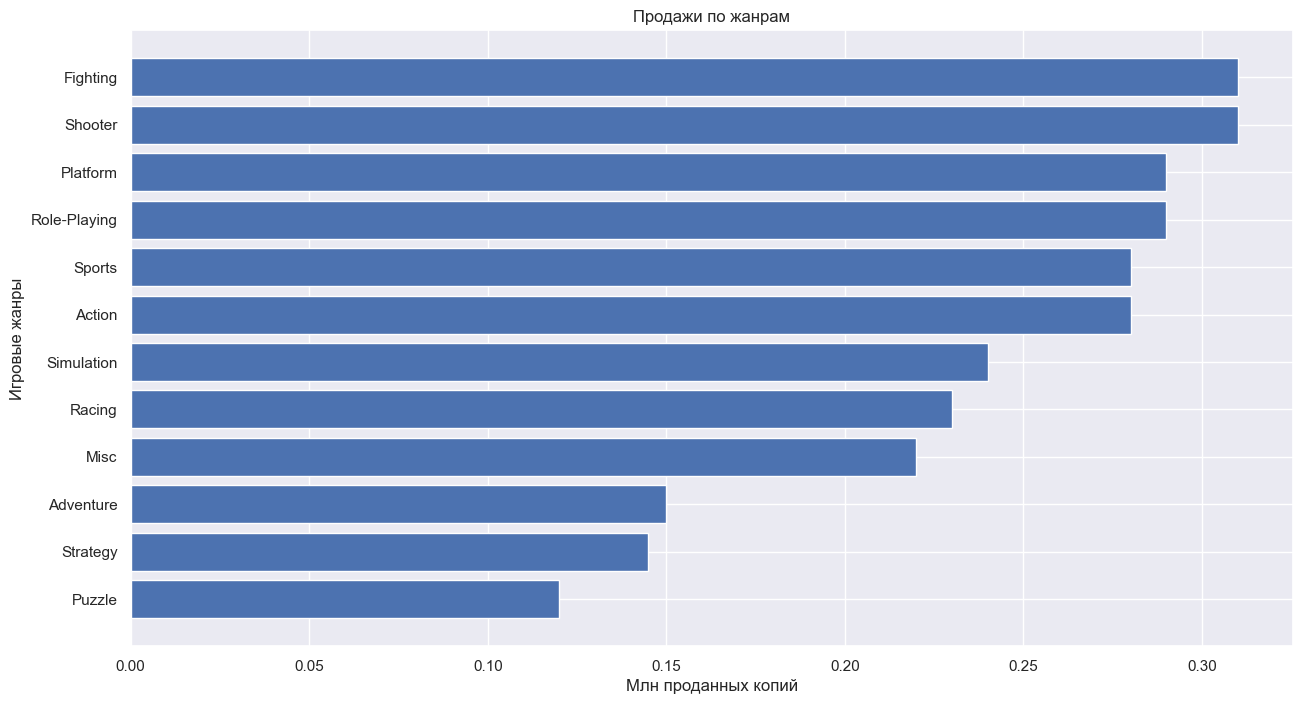

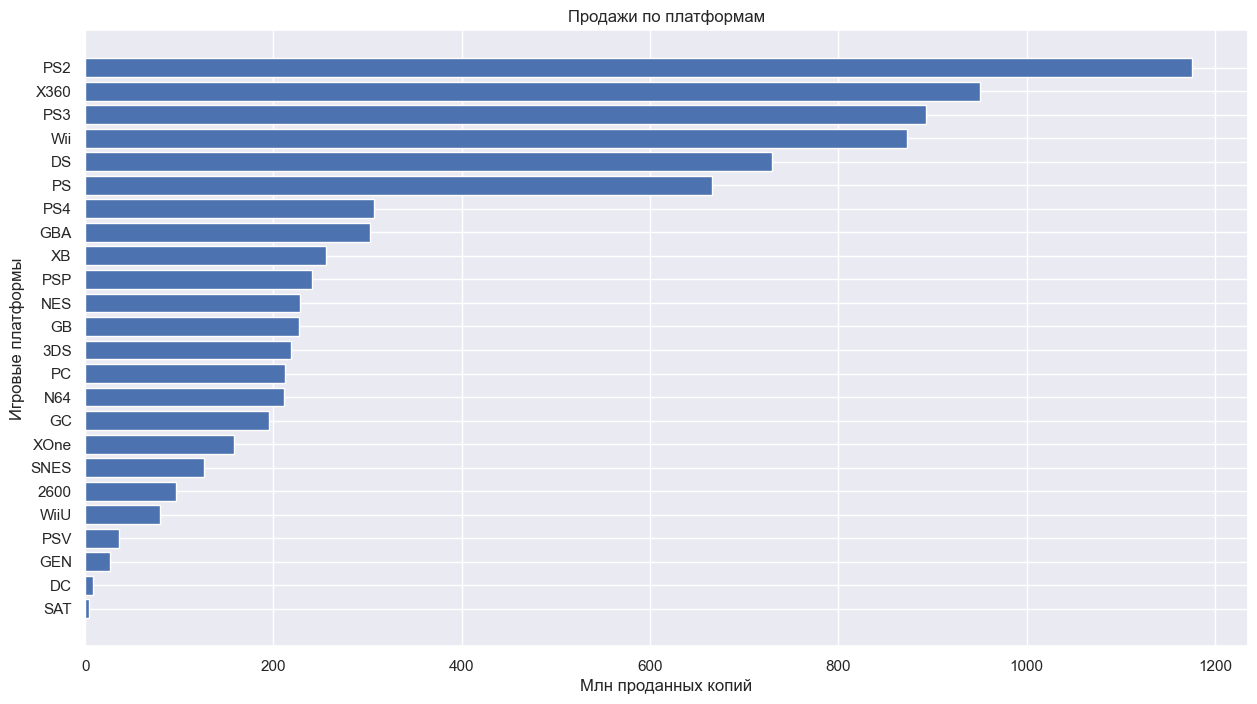

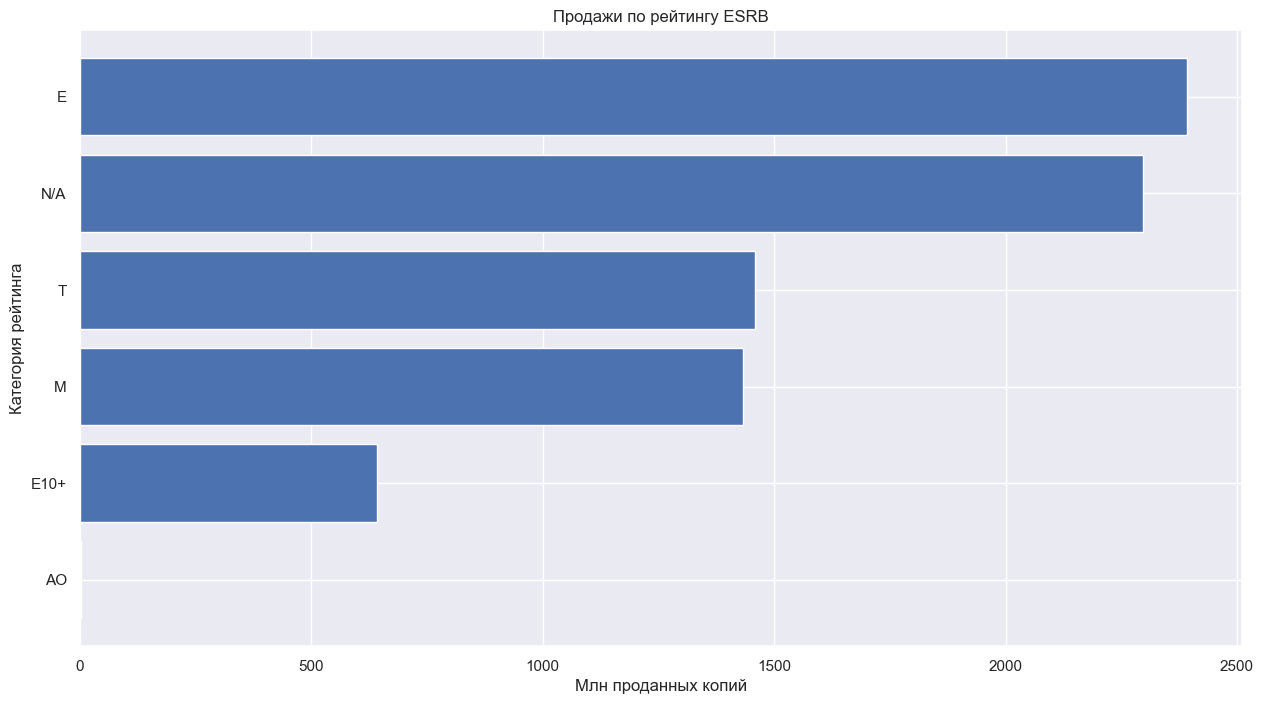

In [58]:
portrait('na_sales')

Самыми популярными играми в Северной Америке являются игры жанра Fighting и Shooter. Играют чаще всего на PS2, реже на X360, Wii, PS3/PS и DS. Играют в игры для всех возрастов, игры для взрослых непопулярны, совсем.

#### Европа

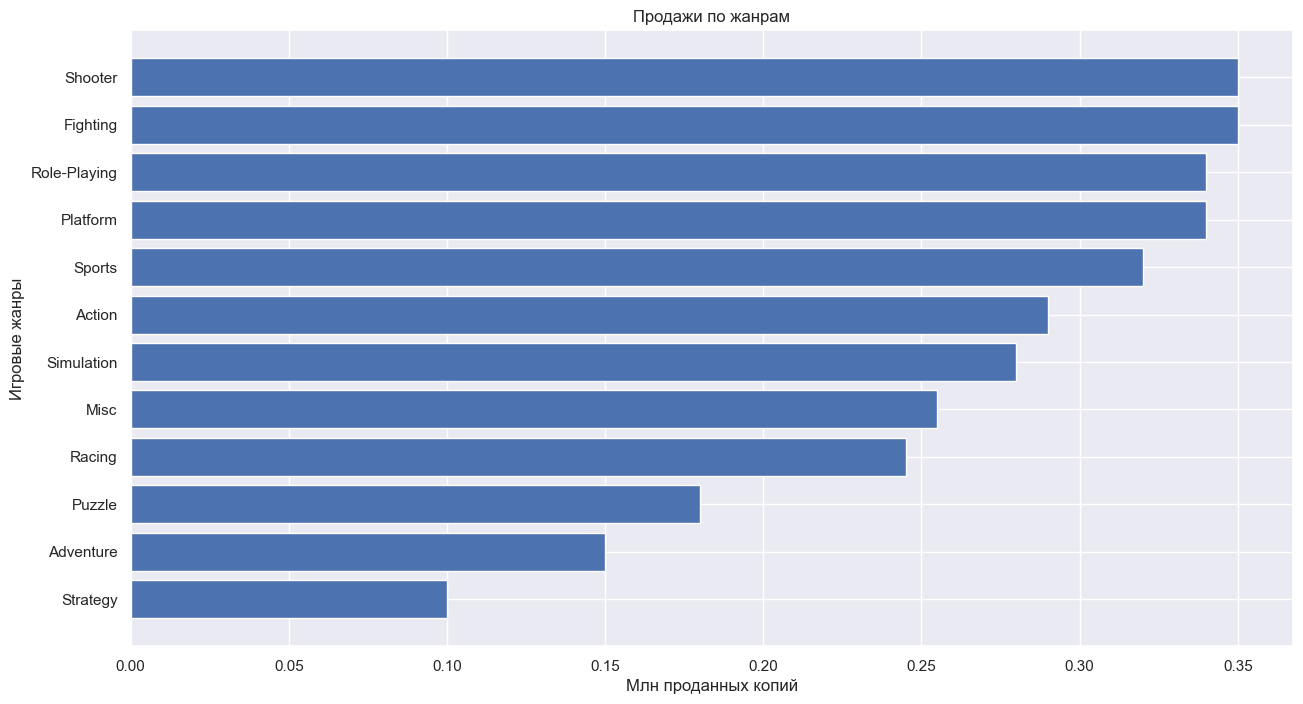

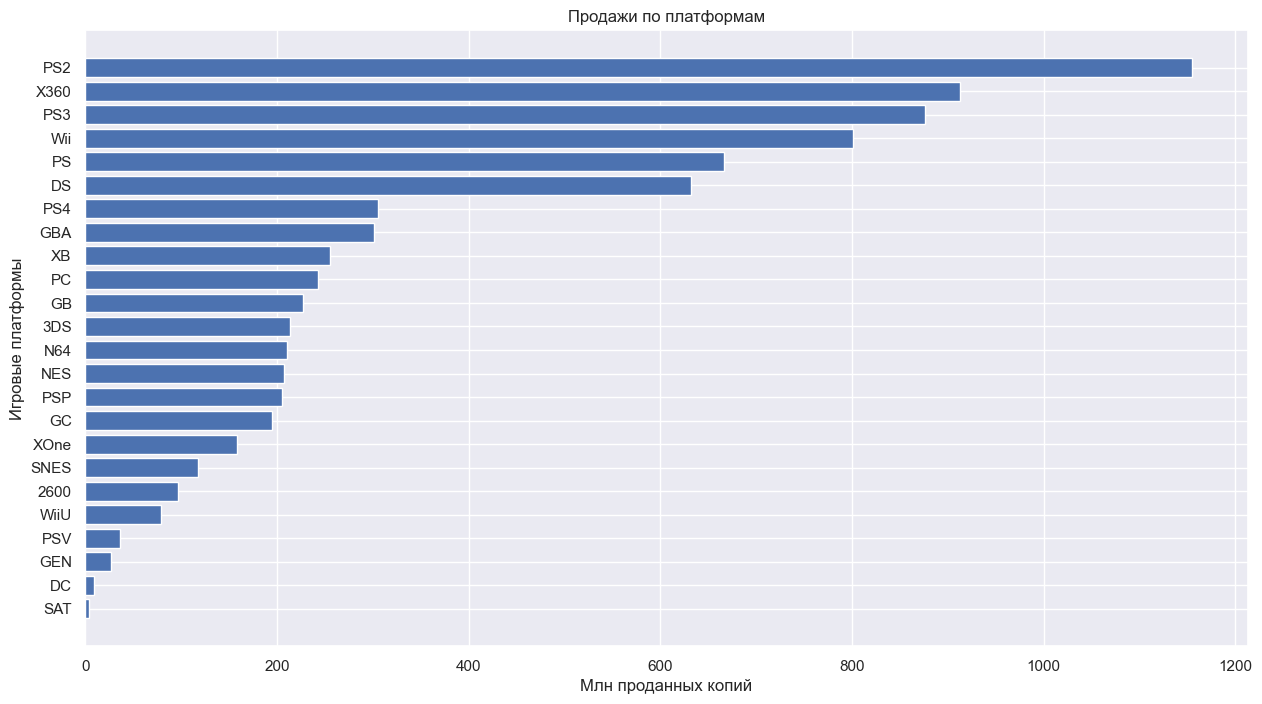

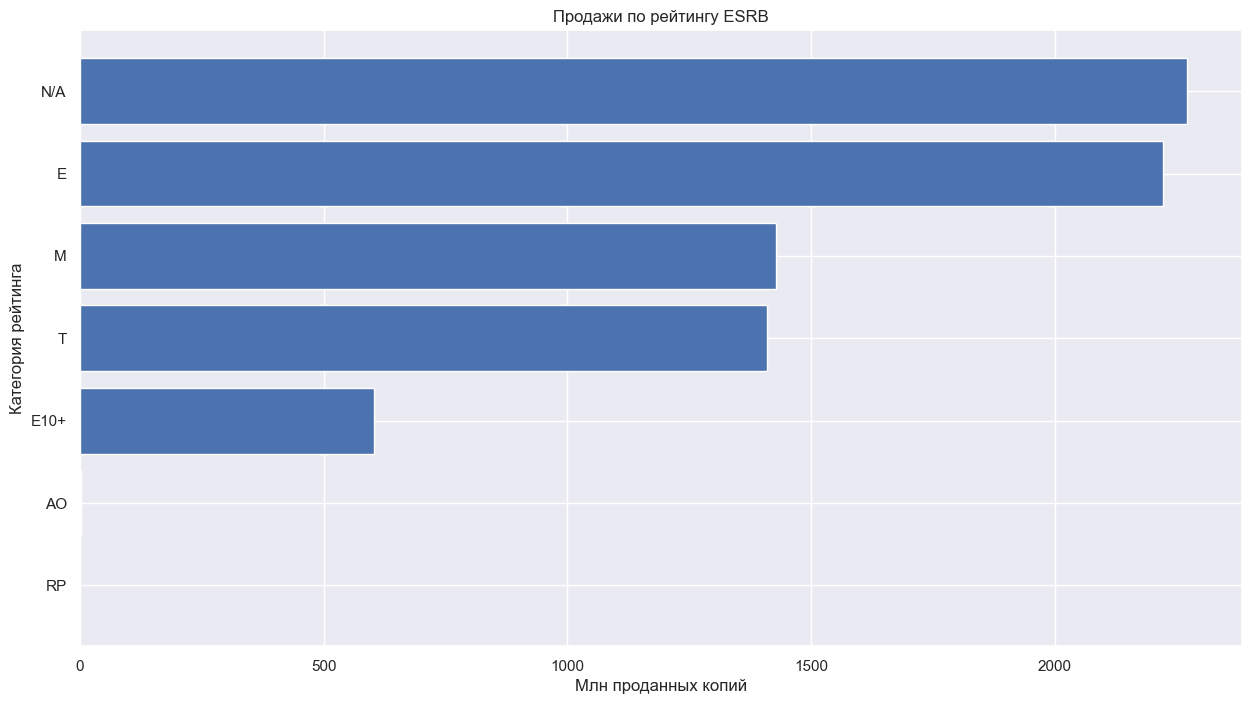

In [59]:
portrait('eu_sales')

Самыми популярными играми в Европе, как и в Америке являются игры жанра Fighting и Shooter. Играют чаще всего на PS2, реже на X360, Wii, PS3/PS и DS. Играют в игры для всех возрастов, игры для взрослых не продавались.

#### Япония

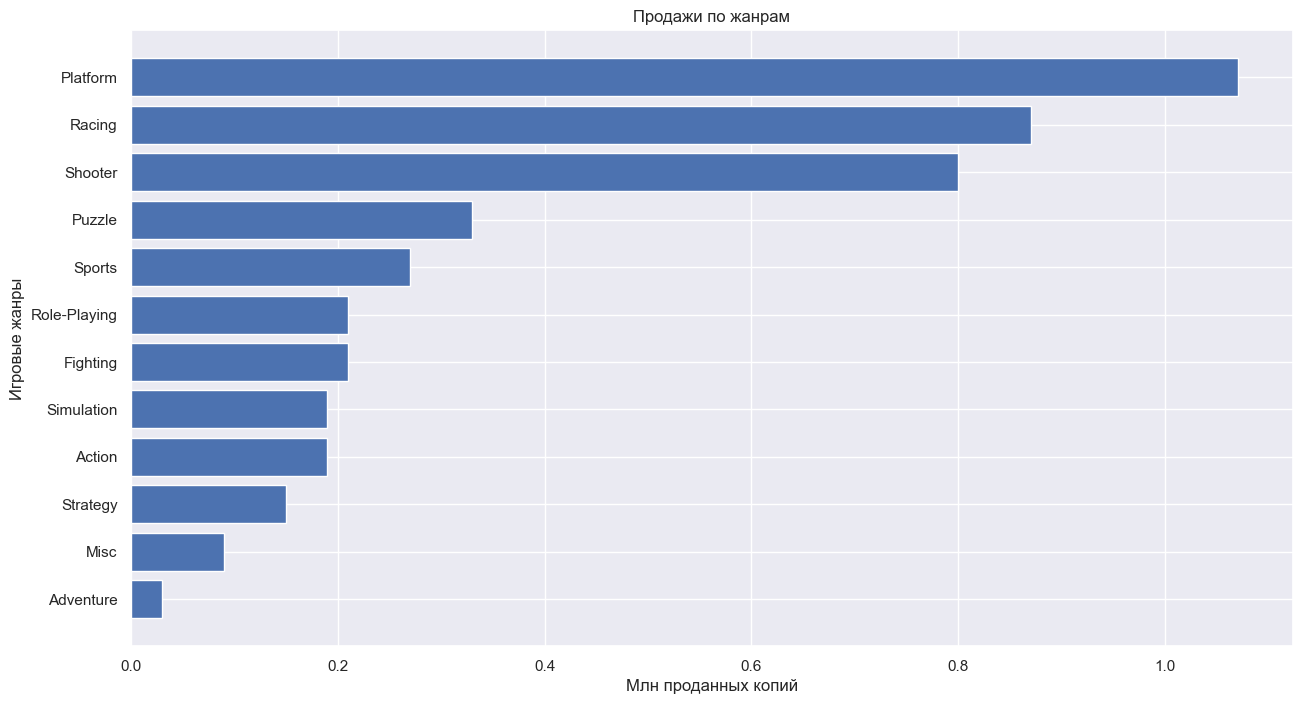

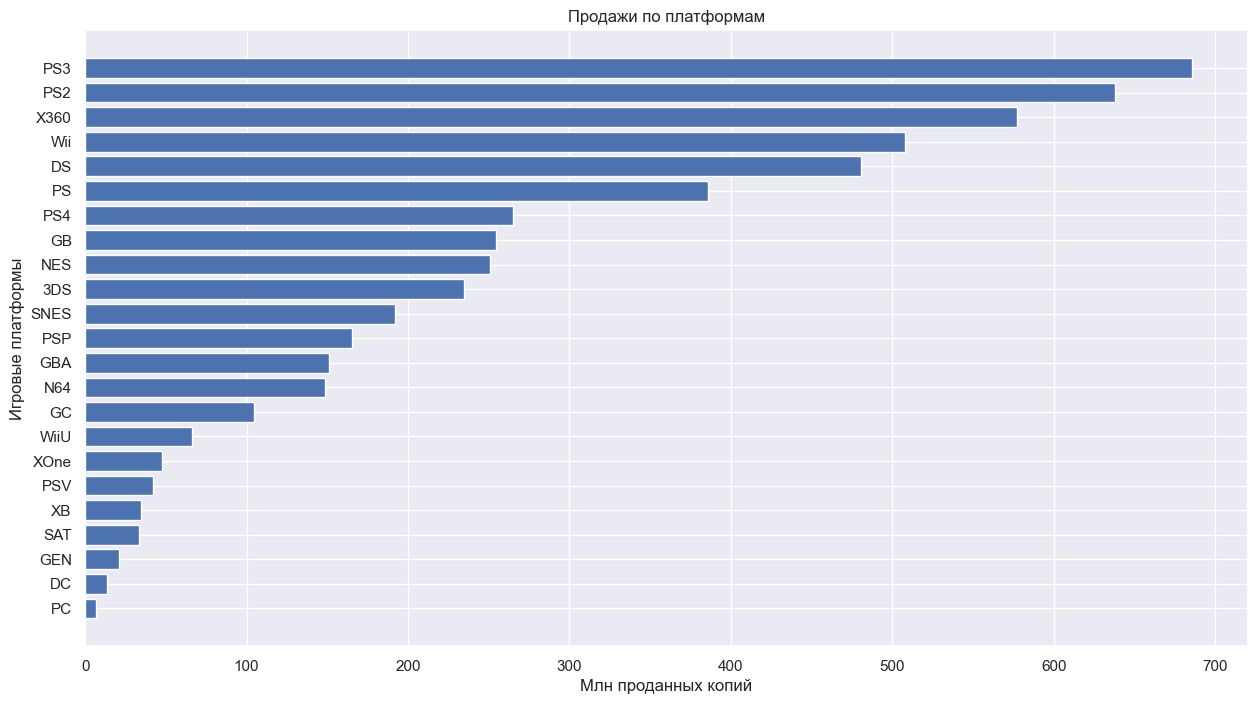

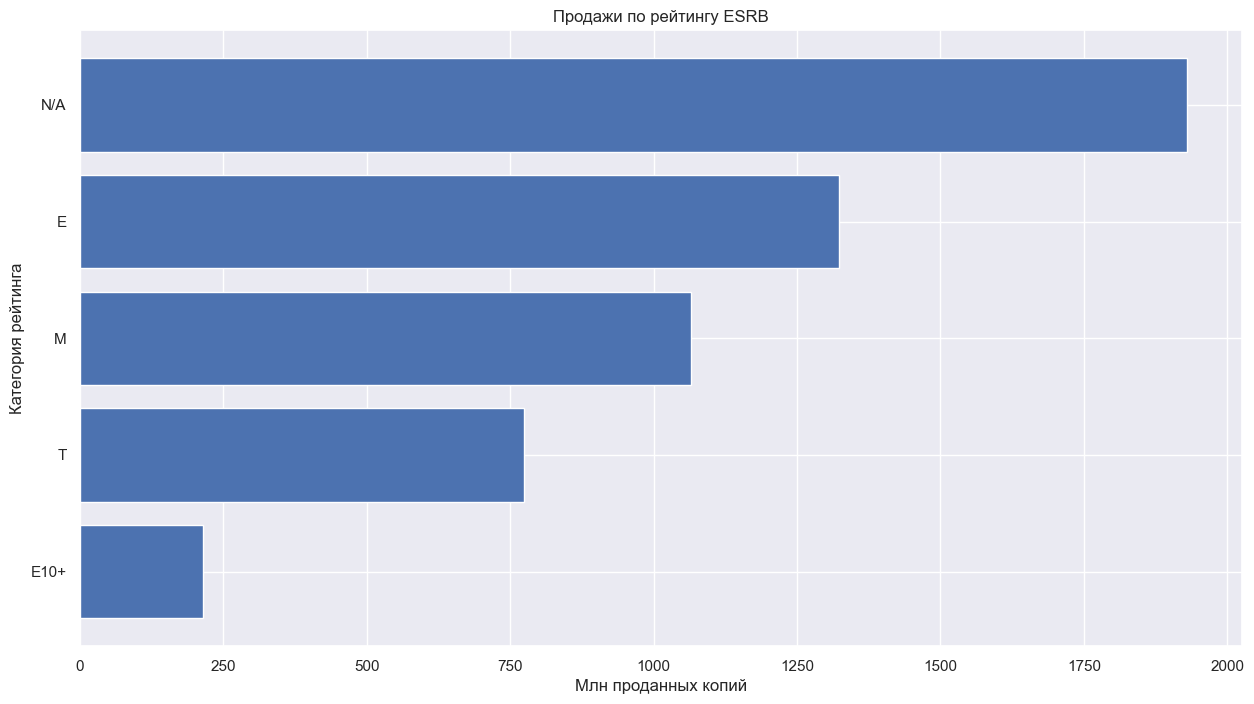

In [60]:
portrait('jp_sales')

Самыми популярными играми в Японии являются игры жанра Platform, Racing и Shooter. Играют чаще всего на PS3 и PS2, реже на X360, Wii и DS. Играют в игры для всех возрастов и в игры для детей старше 17.

#### Вывод

Портрет Американского и Европейского позльзователя очень схож меду собой, в обоих регионах лидируют жанры Fighting и Shooter. Японские же пользователи выделяются из общей массы Platform и Racing, также значительно большей популярностью в данном регионе пользуются игры жанра Puzzle.

В части игровых платформ, Япония также выделяется. Так исторически сложилось, что платформа PS, японского происхождения, крайне популярна в родной стране, в то время как в Северной Америке и Европе разница между платформами, помимо PS2, не так сильно выражена.

Что же касается рейтинга ESRB, действительно можно заметить, что в Японии, по сравнению с другими регионами, игры для всех возрастов чуть менее популярны, и чуть более популярны игры с возрастным ограничением 17+ ('М') и 13+ ('T')

### Проверка гипотез

#### Гипотеза №1

Проверим гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Нулевая гипотеза: средние значения рейтинга Xbox One и PC равны. Альтернативная гипотеза: среднее значение рейтинга Xbox One и среднее значение рейтинга PC неравны.

Поскольку проверяется двусторонняя гипотеза: равны или не равны средние, в качестве аргумента alternative примем значение 'two-sided', используемое при проверках двусторонней гипотезы.

In [61]:
df_xone = df.loc[df['platform'] == 'XOne']
df_pc = df.loc[df['platform'] == 'PC']
display(f'Размер данных XOne: {df_xone.id.count()}')
display(f'Размер данных PC: {df_pc.id.count()}')

'Размер данных XOne: 242'

'Размер данных PC: 964'

In [62]:
xone_sample = df_xone.sample(n=240)
pc_sample = df_pc.sample(n=240)

alpha = 0.05

us_platform_results = st.ttest_ind(
    xone_sample.user_score,
    pc_sample.user_score,
    alternative='two-sided'
)

print(f'p-value: {us_platform_results.pvalue}')

# Проверяем p-value:
if us_platform_results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, средние рейтинги Xbox One и PC неравны')
else:
    print('Нет оснований отвергнуть нулевую гипотезу, средние рейтинги Xbox One и PC одинаковые')
    
print()
print(f'Среднее значение пользовательского рейтинга Xbox One: {df_xone.user_score.mean()}')
print(f'Среднее значение пользовательского рейтинга PC: {df_pc.user_score.mean()}')

p-value: 9.016511212812206e-05
Отвергаем нулевую гипотезу, средние рейтинги Xbox One и PC неравны

Среднее значение пользовательского рейтинга Xbox One: 6.726653099060059
Среднее значение пользовательского рейтинга PC: 7.191130638122559


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основание полагать что рейтинги неравны.

#### Гипотеза №2

Проверим гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные.

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны. Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports неравны.

In [63]:
df_action = df.loc[df['genre'] == 'Action']
df_sports = df.loc[df['genre'] == 'Sports']
display(f'Размер данных по жанру Action: {df_action.id.count()}')
display(f'Размер данных по жанру Sports: {df_sports.id.count()}')

'Размер данных по жанру Action: 3313'

'Размер данных по жанру Sports: 2303'

In [64]:
action_sample = df_action.sample(n=2300)
sports_sample = df_sports.sample(n=2300)

alpha = 0.05

us_genre_results = st.ttest_ind(
    xone_sample.user_score,
    pc_sample.user_score,
    alternative='two-sided'
)

print(f'p-value: {us_genre_results.pvalue}')

# Проверяем p-value:
if us_genre_results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, средние рейтинги жанров Action и Sports неравны')
else:
    print('Нет оснований отвергнуть нулевую гипотезу, средние рейтинги жанров Action и Sports одинаковые')
    
print()
print(f'Среднее значение пользовательского рейтинга жанра Action: {df_action.user_score.mean()}')
print(f'Среднее значение пользовательского рейтинга жанра Sports: {df_sports.user_score.mean()}')

p-value: 9.016511212812206e-05
Отвергаем нулевую гипотезу, средние рейтинги жанров Action и Sports неравны

Среднее значение пользовательского рейтинга жанра Action: 7.249788761138916
Среднее значение пользовательского рейтинга жанра Sports: 7.333608627319336


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основание полагать что рейтинги неравны.

#### Вывод

Для проверки гипотез мы использовали специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам (scipy.stats.ttest_ind), поскольку сравниваемые выборки являются генеральными совокупностями в обоих случаях.
Поскольку проверяется двусторонняя гипотеза: равны или не равны средние, в качестве аргумента alternative мы приняли значение 'two-sided', используемое при проверках двусторонней гипотезы.

Гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, мы опровергли. Есть основание полагать что рейтинги неравны. Средние значения рейтингов платформ Xbox One и PC в результате усреднения значения по категории в имеющемся датасете составили 6.7 и 7.2 соответственно.

Гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные, мы подтвердили. По результатам расчета среднего значения по категории они действительно отличаются, хотя и не на много. Среднее значение пользовательского рейтинга жанра Action составило 7.25, а жанра Sports 7.33.

### Вывод

В рамках анализа датасета с информацией об играх, их рейтингах и их продажах в различных регионах, была осуществлена предварительная обработка данных, а именно, мы провели работу по изменению регистра столбцов, проверили датафрейм на предмет явных и неявных дубликатов, устранили лишние пробелы в названии игр, а также провели работу по устранению пропусков и форматированию данных. Мы проанализировали данные на предмет аномальных значений и исключили из датафрейма игры без указания продаж, а также с нулевым и аномально низким рейтингом.
По результатам предварительной обработки доля данных от общего объема, которыми мы пожертвовали, составила 1,7%.

Наиболее чувствительным для нас оказалось отсутствие данных в колонках с информацией о пользовательском рейтинге и рейтинге критиков. Причиной отсутствия указанных данных может быть технических сбой при формировании или хранении и передаче данных, отсутствие данной аналитики как таковой в период релиза игры, а также просто отсутствие оценок в том числе по играм, которые на момент формирования данной аналитики еще не были оценены пользователями в силу раннего релиза.
  
По результатам исследовательского анализа данных мы выяснили, что количество игр, выпускаемых с 1980 по 1992 год на порядки меньше количества игр выпускаемых с середины 2000х и вплоть до 2016 года, а пик выпуска игр пришелся на 2008-2009 года.
Выяснили, что жизненный цикл платформ ограничен примерно 10 годами, при этом, с каждым годом конкурентам требуется все меньше времени, чтобы навязать конкуренцию платформам, набирающим популярность. 
Сделали прогноз о прибыльности и увеличения аудитории флагманской платформы от Sony (PS4) и ее прямого конкурента от Microsoft (XOne) в перспективе 2-3 лет до момента выпуска нового поколения данных консолей.
А также предположили, что продажи на каждой из платформ имеют свою специфику, а именно чем чаще релизы тем ниже медианное значение, чем реже выходят платформенные новинки тем медианное значение продаж выше, 
а корреляция между продажами и рейтингом по большинству из рассматриваемых платформам либо слабо положительная, либо вовсе отсутствует. Такое возможно просто потому, что на момент выхода игр на некоторых платформах оценки и критиков и игроков для пользователей были недоступны из-за отсутствия интернета.
  
Изучили общую статистику по жанрам и узнали, что лидером среди жанров являются Platform-игры. На втором месте Shooter, на третьем Sports, а вот Puzzle, Strategy и Adventure пользуются наименьшей популярностью.
  
Сформировали портрет американского, европейского и японского пользователей.
В Северной Америке и Европе лидируют жанры Fighting и Shooter, а японские пользователи, помимо  Platform и Racing игр, в отличие от американского или европейского пользователя выделяют также игры жанра игры жанра Puzzle.
  
В части игровых платформ, Япония, исторически поддерживает отечественную PS разных поколений, в то время как в Северной Америке и Европе разница между платформами, помимо PS2, не так сильно выражена.
Что же касается рейтинга ESRB, в Японии, по сравнению с другими регионами, игры для всех возрастов чуть менее популярны, и чуть более популярны игры с возрастным ограничением 17+ ('М') и 13+ ('T')
  
И в завершение нашего исследования мы проверили две гипотезы, о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, и о том, что средние пользовательские рейтинги жанров Action и Sports разные.
Есть основание полагать что рейтинги Xbox One и PC неравны. Средние значения рейтингов платформ Xbox One и PC составили 6.7 и 7.2 соответственно.
А по результатам расчета среднего значения по жанрам Action и Sports, подтвердились, что они действительно отличаются, хотя и не на много. Среднее значение пользовательского рейтинга жанра Action составило 7.25, а жанра Sports 7.33.